## circuiti_3

In [1]:
import numpy as np
import pandas as pd
import sys
import os
sys.path.append("D:/Progetti/LabProgram")
from Routine import Routine
from Funnel import Funnel 
import lab_utilities as lu
from matplotlib import pyplot as plt
from scipy.signal import hilbert
import re

In [2]:
lu.setDefaultGraphStyle()

### Help function

In [3]:
#Function to find amlitude of a signal with error, with fourier transform
def findAmpFourier(signal):
    #Fourier transform
    fft = np.fft.fft(signal)
    #Find frequency with max amplitude
    maxFreq = np.argmax(np.abs(fft))
    #Find amplitude
    amp = np.abs(fft[maxFreq])
    #Find error
    err = 0
    return amp, err


In [4]:

#signal must contain time, voltage, time error, voltage error
def findAmplitude(signal, freq):
    maxes = [] #must contain (max_index, max_value, max_error)
    mins = [] #must contain (min_index, min_value, min_error)
    max_index = np.argmax(signal[1])
    T = 1/freq
    if(signal[0][max_index] - signal[0][-1] > T/2):
        positivie = True
        start_point = signal[0][max_index] + T/4
    else:
        start_point = signal[0][max_index] - T/4
        positivie = False
    #divide signal in parts of T/2
    left_cuts = [l for l in np.arange(start_point, signal[0][-1], T/2)]
    right_cuts = [r for r in np.arange(start_point, signal[0][0], -T/2)]
    cuts = left_cuts + right_cuts

    cut_signal = []
    for c in cuts: #put cuts in the signal
        index_nearest = np.argmin(np.abs(signal[0] - c))
        cut_signal.append(index_nearest)
    #sort cuts
    cut_signal.sort()

    #####Debug:
    #plt.figure()
    #plt.plot(signal[0], signal[1], '.')
    ##add vertical lines for cuts
    #for c in cut_signal:
    #    plt.axvline(signal[0][c], color = 'r')
    ##plt.show()
    ######
    
    #cuts in the middle
    for i in range(len(cut_signal) - 1):
        cut = signal[1][cut_signal[i]:cut_signal[i+1]]
        #if the cut is empty, skip it
        if(len(cut) == 0):
            continue
        max_index = np.argmax(cut)
        min_index = np.argmin(cut)
        #find max_index and min_index in the signal
        max_index = cut_signal[i] + max_index
        min_index = cut_signal[i] + min_index
        #right one is the one most distant from zero
        if (np.abs(signal[1][max_index]) > np.abs(signal[1][min_index])):
            maxes.append((max_index, signal[1][max_index], signal[3][max_index]))
        else:
            mins.append((min_index, signal[1][min_index], signal[3][min_index]))

    #find amplitude as weighted mean of abs of maxes and mins
    abs_values = [np.abs(m[1]) for m in maxes + mins]
    weights = []
    for m in maxes + mins:
        if m[2] == 0:
            weights.append(1/0.001**2)
        else:
            weights.append(1/m[2]**2)
    
    amp = np.mean(abs_values)
    #err is 1/sum(1/error)**2
    err = lu.st_dev(np.array(abs_values))
    return amp, err

In [5]:
def phase_diff(d1, d2):
    """Compute the phase difference between two signals"""
    analytic_signal1 = hilbert(d1)
    analytic_signal2 = hilbert(d2)
    c = np.inner( analytic_signal1, np.conj(analytic_signal2) ) / np.sqrt( np.inner(analytic_signal1,np.conj(analytic_signal1)) * np.inner(analytic_signal2,np.conj(analytic_signal2)) )
    #error_c = np.sqrt( (1 - c**2) / (N - 1) ) * err_d1 * err_d2 / (abs(c) * np.sqrt(np.inner(analytic_signal1, np.conj(analytic_signal1)) * np.inner(analytic_signal2, np.conj(analytic_signal2))) )
    return (np.angle(c))

## Parte 1

In [5]:
#load the data
data_gen = pd.read_csv("data/RC/132_5/F0000CH1.CSV")
data_gen = data_gen.iloc[18:]
data_gen = data_gen.iloc[:,[3,4]]
data_gen.columns = ["time", "voltage"]
data_ch2 = pd.read_csv("data/RC/132_5/F0000CH2.CSV")
data_ch2 = data_ch2.iloc[18:]
data_ch2 = data_ch2.iloc[:,[3,4]]
data_ch2.columns = ["time", "voltage"]
data_math = pd.read_csv("data/RC/132_5/F0000MTH.CSV")
data_math = data_math.iloc[18:]
data_math = data_math.iloc[:,[3,4]]
data_math.columns = ["time", "voltage"]

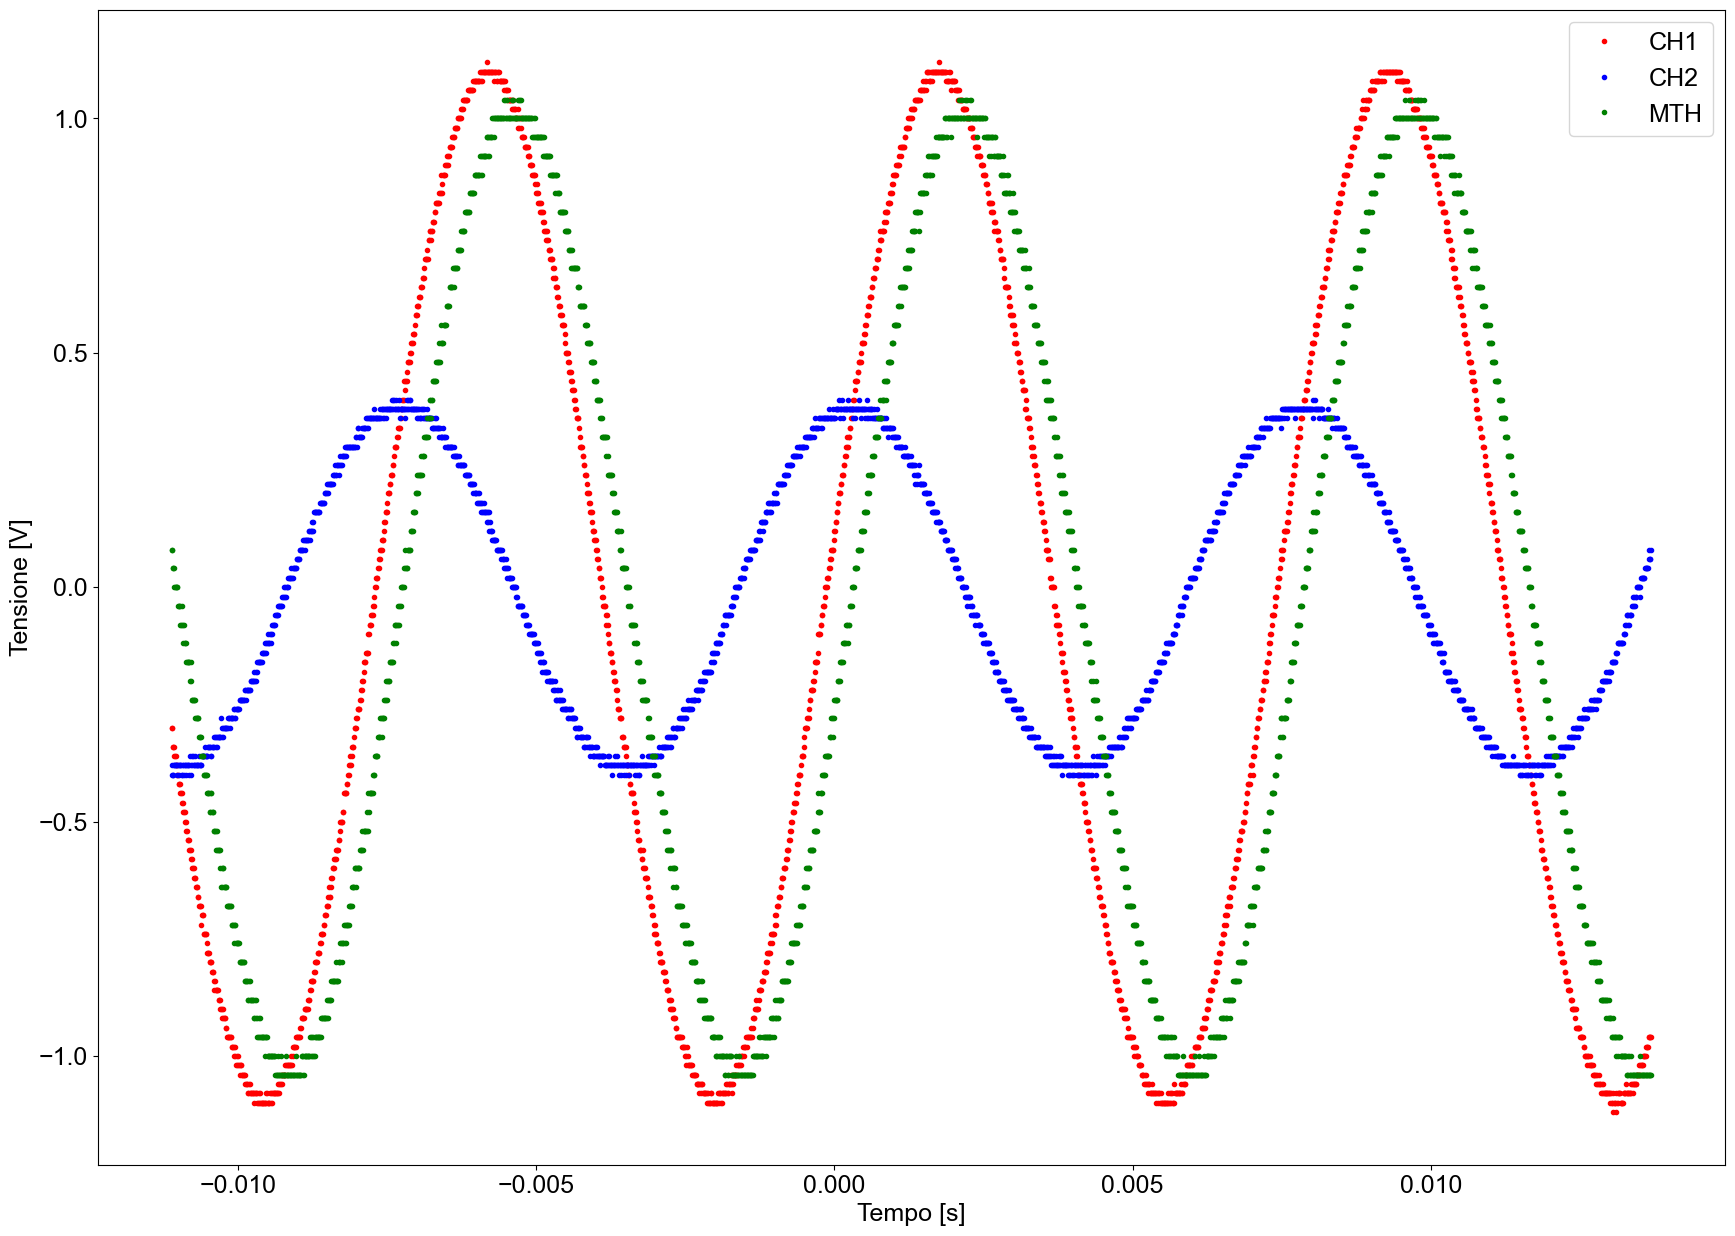

In [6]:
#plot all the data in one graph
plt.plot(data_gen["time"], data_gen["voltage"], "r." ,label="CH1")
plt.plot(data_ch2["time"], data_ch2["voltage"], "b." ,label="CH2")
plt.plot(data_math["time"], data_math["voltage"], "g." ,label="MTH")
plt.xlabel("Tempo [s]")
plt.ylabel("Tensione [V]")
plt.legend()

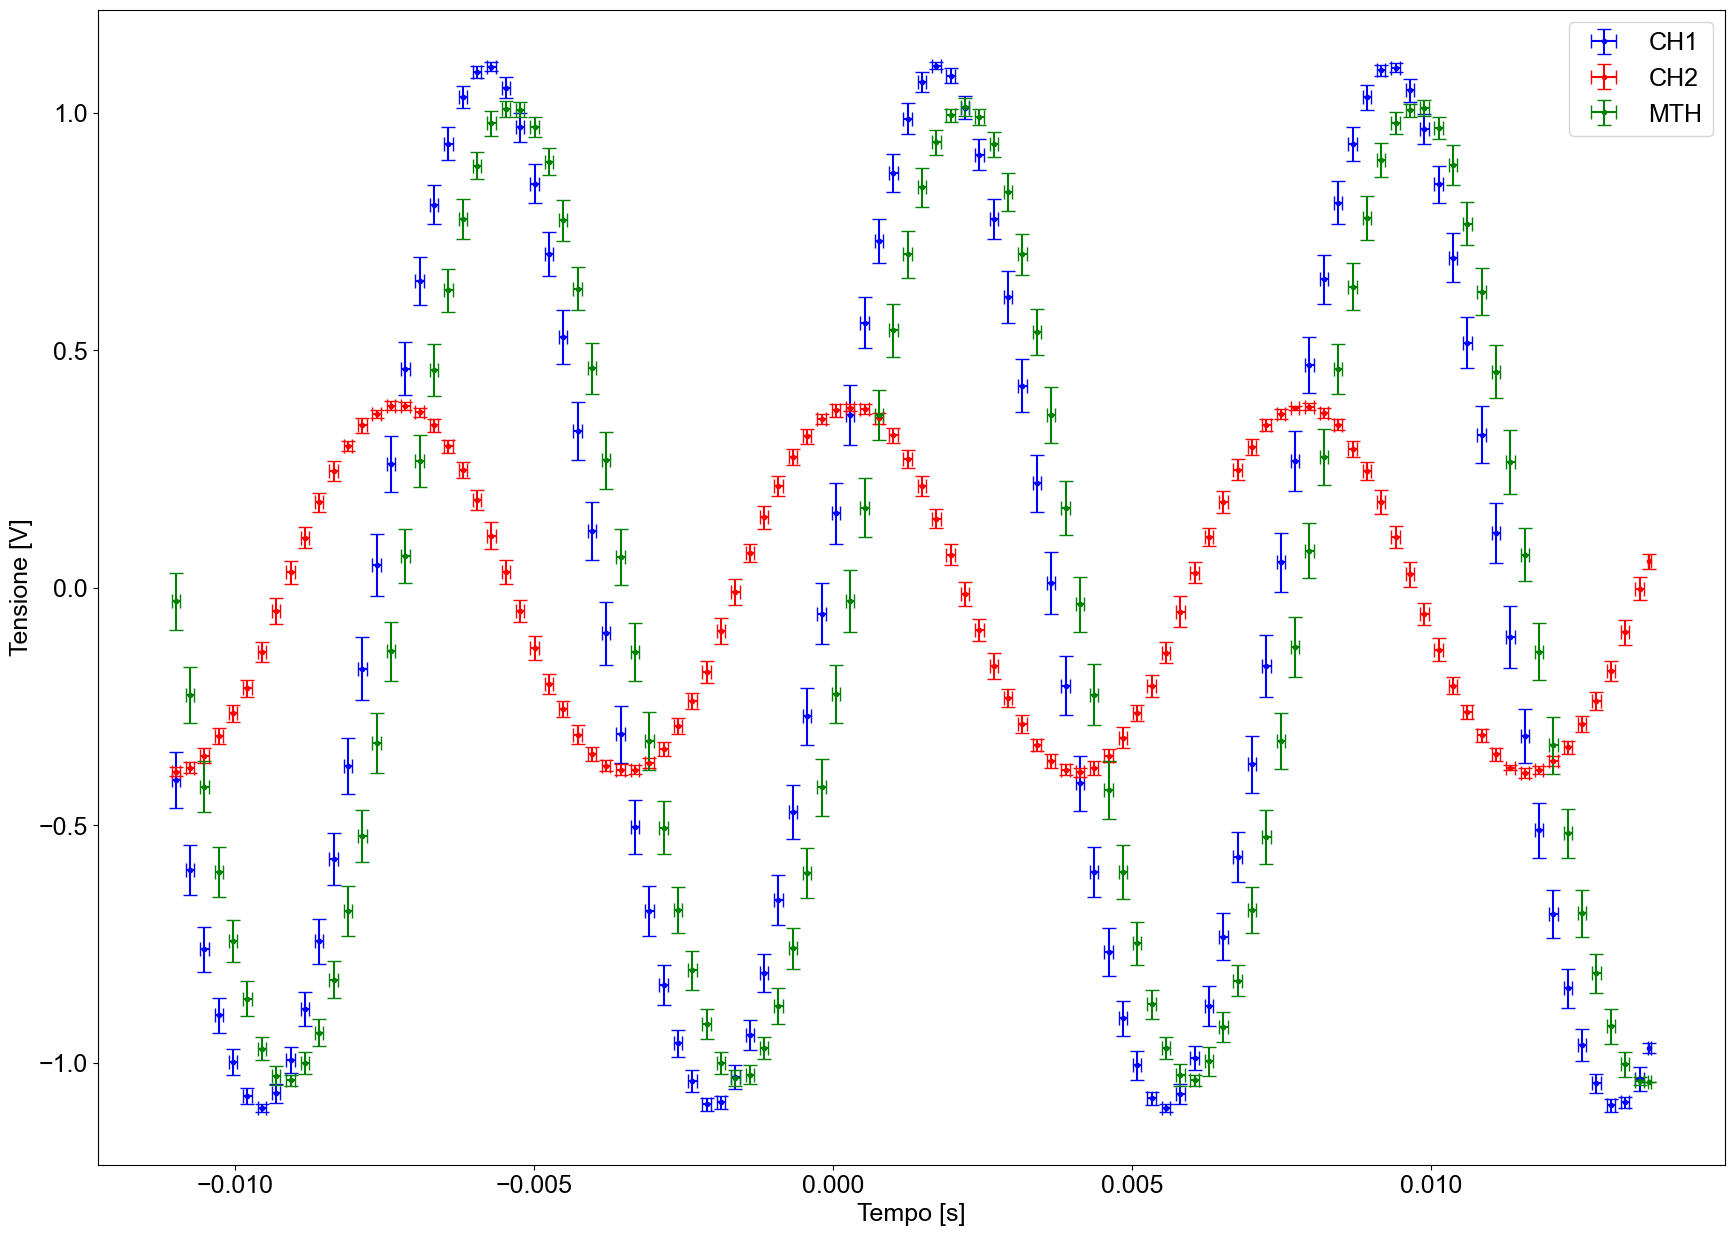

In [7]:
clustered_data_gen = lu.simple_sampling(data_gen["time"], data_gen["voltage"], 100)
clustered_data_ch2 = lu.simple_sampling(data_ch2["time"], data_ch2["voltage"], 100)
clustered_data_math = lu.simple_sampling(data_math["time"], data_math["voltage"], 100)
plt.errorbar(clustered_data_gen[0], clustered_data_gen[1], xerr=clustered_data_gen[2], yerr=clustered_data_gen[3], fmt="b.", label="CH1")
plt.errorbar(clustered_data_ch2[0], clustered_data_ch2[1], xerr=clustered_data_ch2[2], yerr=clustered_data_ch2[3], fmt="r.", label="CH2")
plt.errorbar(clustered_data_math[0], clustered_data_math[1], xerr=clustered_data_math[2], yerr=clustered_data_math[3], fmt="g.", label="MTH")
plt.xlabel("Tempo [s]")
plt.ylabel("Tensione [V]")
plt.legend()

In [8]:
print("phase difference: ", phase_diff(data_gen["voltage"], data_ch2["voltage"]))

phase difference:  -1.1747754692200405


In [11]:
#TO RENAME

def renameOscilloscope(path):
    for subdir, dirs, files in os.walk(path):
        for filename in files:
            if (".CSV" in filename and "F" in filename):
                #new name = old name from first charachter to -9 characters before end + "0" + old name from -8 charachters before end to end
                new_filename = filename[:-9] + "00" + filename[-7:]
                os.rename(os.path.join(subdir, filename), os.path.join(subdir, new_filename))

0.00824700449864535 0.009970000044955438
0.018564546210106964 0.019581205669403953
0.010650734580455288 0.010000489308423875
0.011528178260635284 0.013018229158511375
0.00722808178848773 0.007517101951832505
0.00941522219059118 0.014063610815045228
0.010927530863228114 0.011178182330900954
0.006888348412777831 0.007880806739321825
0.008806917861638381 0.00979725427740909
0.009178404953534763 0.010290895654214684
0.01006488742239625 0.011022862769761926
0.010671287048820683 0.012680761109751453
0.013464944617284131 0.012701917947979232
0.012462947207964691 0.0137118855630168
0.01468760233424231 0.01623350009560746


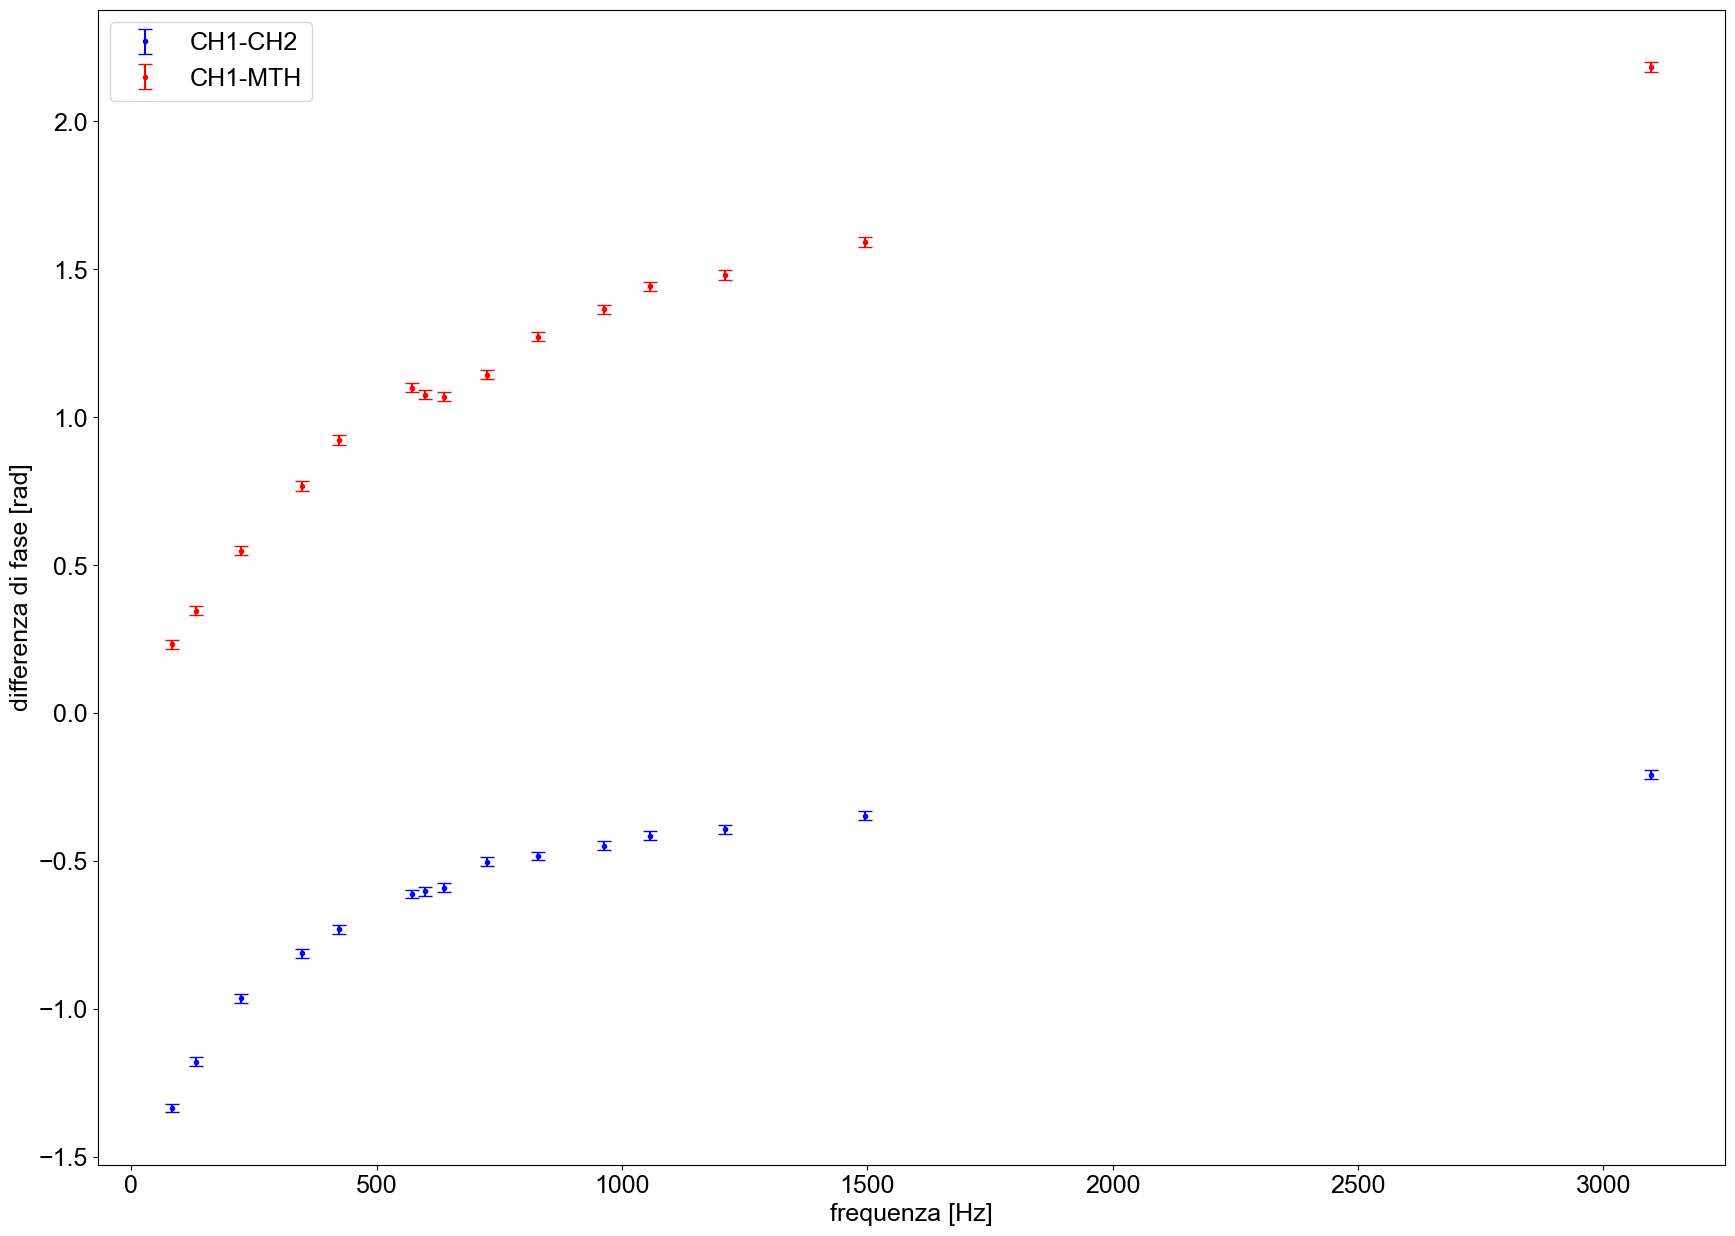

In [48]:
"""Read all the folders in the data folder and compute the phase difference between the two channels"""
#loop over all the folders
phase_diff_ch1_ch2_list = []
phase_diff_ch1_mth_list = []
freqencies = []
for folder in os.listdir("data/RC"):
    #load the data
    #check if the folder is a folder
    if os.path.isdir("data/RC/"+folder):
        data_gen = pd.read_csv("data/RC/"+folder+"/F0000CH1.CSV")
        data_gen = data_gen.iloc[18:]
        data_gen = data_gen.iloc[:,[3,4]]
        data_gen.columns = ["time", "voltage"]
        data_ch2 = pd.read_csv("data/RC/"+folder+"/F0000CH2.CSV")
        data_ch2 = data_ch2.iloc[18:]
        data_ch2 = data_ch2.iloc[:,[3,4]]
        data_ch2.columns = ["time", "voltage"]
        daata_mth = pd.read_csv("data/RC/"+folder+"/F0000MTH.CSV")
        daata_mth = daata_mth.iloc[18:]
        daata_mth = daata_mth.iloc[:,[3,4]]
        daata_mth.columns = ["time", "voltage"]
        #compute the phase difference
        ######
        sampled_ch1 = lu.simple_sampling(data_gen["time"], data_gen["voltage"], 100)
        sampled_ch2 = lu.simple_sampling(data_ch2["time"], data_ch2["voltage"], 100)
        sampled_mth = lu.simple_sampling(daata_mth["time"], daata_mth["voltage"], 100)
        ######
        phase_diff_ch1_ch2_result, err_diff_ch1_ch2 = lu.MCERP_series(phase_diff, [sampled_ch1[1], sampled_ch2[1]], [sampled_ch1[3], sampled_ch2[3]], n=10000)
        phase_diff_ch1_mth_result, err_diff_ch1_mth = lu.MCERP_series(phase_diff, [sampled_ch1[1], sampled_mth[1]], [sampled_ch1[3], sampled_mth[3]], n=10000)
        phase_diff_ch1_ch2_list.append(phase_diff_ch1_ch2_result)
        phase_diff_ch1_mth_list.append(phase_diff_ch1_mth_result)
        #get the frequency as the name of the folder where "_" = "."
        freqencies.append(float(folder.replace("_",".")))
        print(err_diff_ch1_ch2, err_diff_ch1_mth)

#plot the phase difference with error bars
plt.errorbar(freqencies, phase_diff_ch1_ch2_list, yerr=err_diff_ch1_ch2, fmt="b.", label="CH1-CH2")
plt.errorbar(freqencies, phase_diff_ch1_mth_list, yerr=err_diff_ch1_mth, fmt="r.", label="CH1-MTH")
#add legend and labels
plt.xlabel("frequenza [Hz]")
plt.ylabel("differenza di fase [rad]")
plt.legend()


In [6]:
def phaseDiffCalc(path, n=1000):
    phase_diff_ch1_ch2_list = []
    err_diff_ch1_ch2_list = []
    phase_diff_ch1_mth_list = []
    err_diff_ch1_mth_list = []
    freqencies = []
    for folder in os.listdir(path):
        if (not os.path.isdir(path+folder )):
            continue
        if (not folder.replace("_", "").isnumeric()):
            continue
        data_gen = pd.read_csv(path+folder+"/F0000CH1.CSV")
        data_gen = data_gen.iloc[18:]
        data_gen = data_gen.iloc[:,[3,4]]
        data_gen.columns = ["time", "voltage"]
        data_ch2 = pd.read_csv(path+folder+"/F0000CH2.CSV")
        data_ch2 = data_ch2.iloc[18:]
        data_ch2 = data_ch2.iloc[:,[3,4]]
        data_ch2.columns = ["time", "voltage"]
        daata_mth = pd.read_csv(path+folder+"/F0000MTH.CSV")
        daata_mth = daata_mth.iloc[18:]
        daata_mth = daata_mth.iloc[:,[3,4]]
        daata_mth.columns = ["time", "voltage"]
        #compute the phase difference
        ######
        sampled_ch1 = lu.simple_sampling(data_gen["time"], data_gen["voltage"], 100)
        sampled_ch2 = lu.simple_sampling(data_ch2["time"], data_ch2["voltage"], 100)
        sampled_mth = lu.simple_sampling(daata_mth["time"], daata_mth["voltage"], 100)
        ######
        phase_diff_ch1_ch2_result, err_diff_ch1_ch2 = lu.MCERP_series(phase_diff, [sampled_ch1[1], sampled_ch2[1]], [sampled_ch1[3], sampled_ch2[3]], n)
        phase_diff_ch1_mth_result, err_diff_ch1_mth = lu.MCERP_series(phase_diff, [sampled_ch1[1], sampled_mth[1]], [sampled_ch1[3], sampled_mth[3]], n)
        phase_diff_ch1_ch2_list.append(phase_diff_ch1_ch2_result)
        err_diff_ch1_ch2_list.append(err_diff_ch1_ch2)
        phase_diff_ch1_mth_list.append(phase_diff_ch1_mth_result)
        err_diff_ch1_mth_list.append(err_diff_ch1_mth)
        #get the frequency as the name of the folder where "_" = "."
        freqencies.append(float(folder.replace("_",".")))
    
    return phase_diff_ch1_ch2_list, err_diff_ch1_ch2_list, phase_diff_ch1_mth_list, err_diff_ch1_mth_list

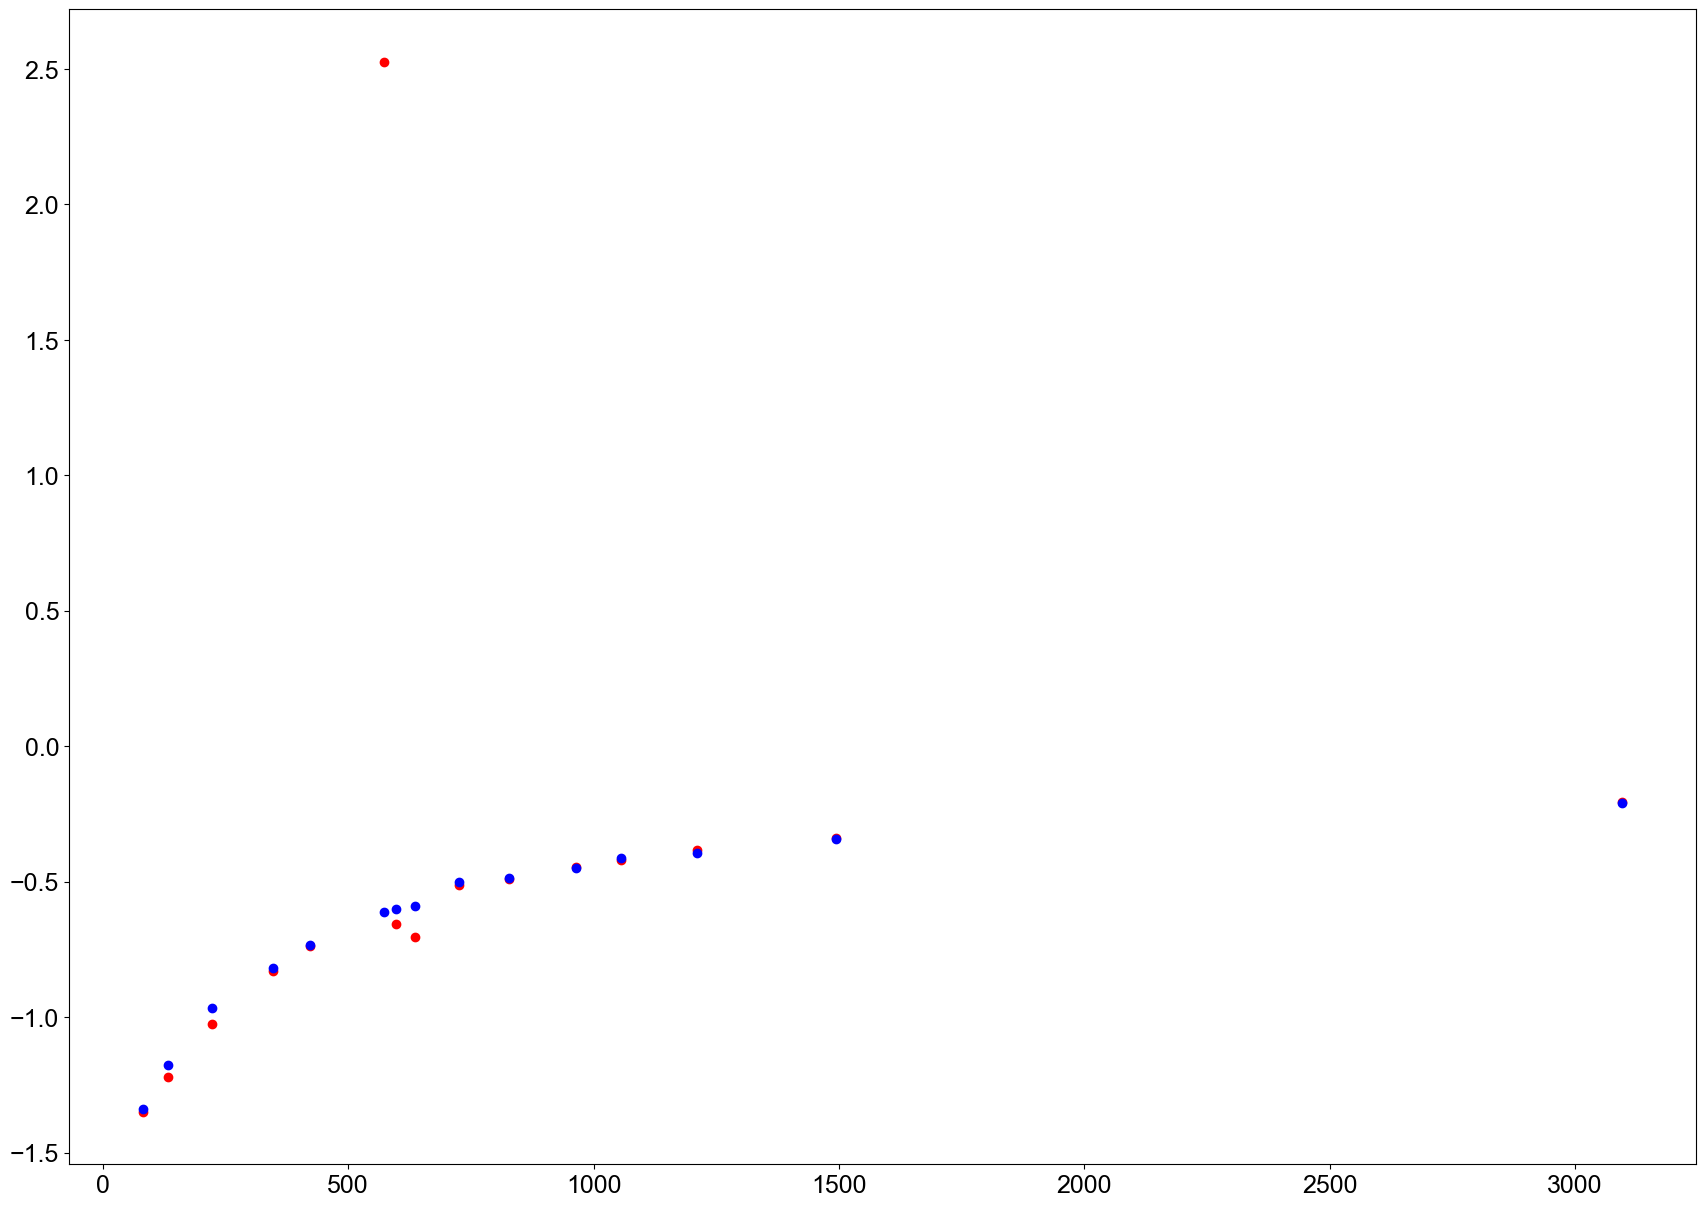

In [28]:
#confront with fit method
fit_data = pd.read_csv("data/RC/phase.csv")
pch1 = fit_data["Phase CH1 (rad)"]
pch2 = fit_data["Phase CH2 (rad)"]
pmth = fit_data["Phase MTH (rad)"]
diff_ch1_ch2 = [pch1[i]-pch2[i] for i in range(len(pch1))]

plt.plot(fit_data["Frequency (Hz)"], diff_ch1_ch2, "ro", label="ch1-ch2")
plt.plot(freqencies, phase_diff_ch1_ch2_list, "bo", label="ch1-ch2")
#Splt.plot(freqencies, pdiff_h2_ch1_list, "go", label="ch1-ch2 H2")

In [11]:
###Convert to clustered data

for folder in os.listdir("data/RC"):
    #read CH1, CH2 and MTH data
    #check if the folder is a folder
    if os.path.isdir("data/RC/"+folder):
        data_gen = pd.read_csv("data/RC/"+folder+"/F0000CH1.CSV")
        data_gen = data_gen.iloc[18:]
        data_gen = data_gen.iloc[:,[3,4]]
        data_gen.columns = ["time", "voltage"]
        data_ch2 = pd.read_csv("data/RC/"+folder+"/F0000CH2.CSV")
        data_ch2 = data_ch2.iloc[18:]
        data_ch2 = data_ch2.iloc[:,[3,4]]
        data_ch2.columns = ["time", "voltage"]
        data_math = pd.read_csv("data/RC/"+folder+"/F0000MTH.CSV")
        data_math = data_math.iloc[18:]
        data_math = data_math.iloc[:,[3,4]]
        data_math.columns = ["time", "voltage"]
        #cluster the data
        data_gen_c_t, data_gen_c_v, data_gen_c_t_err, data_gen_c_v_err = lu.simple_sampling(data_gen["time"], data_gen["voltage"], 100)
        data_ch2_c_t, data_ch2_c_v, data_ch2_c_t_err, data_ch2_c_v_err = lu.simple_sampling(data_ch2["time"], data_ch2["voltage"], 100)
        data_math_c_t, data_math_c_v, data_math_c_t_err, data_math_c_v_err = lu.simple_sampling(data_math["time"], data_math["voltage"], 100)
        #export the data as csv
        data_gen_c = pd.DataFrame({"time": data_gen_c_t, "voltage": data_gen_c_v, "time_err": data_gen_c_t_err, "voltage_err": data_gen_c_v_err})
        data_gen_c.to_csv("data/RC/"+folder+"/CH1_clustered.CSV", index=False)
        data_ch2_c = pd.DataFrame({"time": data_ch2_c_t, "voltage": data_ch2_c_v, "time_err": data_ch2_c_t_err, "voltage_err": data_ch2_c_v_err})
        data_ch2_c.to_csv("data/RC/"+folder+"/CH2_clustered.CSV", index=False)
        data_math_c = pd.DataFrame({"time": data_math_c_t, "voltage": data_math_c_v, "time_err": data_math_c_t_err, "voltage_err": data_math_c_v_err})
        data_math_c.to_csv("data/RC/"+folder+"/MTH_clustered.CSV", index=False)
    

    

In [7]:
###Convert to clustered data
def clusterData(path):
    for folder in os.listdir(path):
        #read CH1, CH2 and MTH data
        #check if the folder is a folder
        if (os.path.isdir(path+folder) and folder.replace("_", "").isnumeric()):
            data_gen = pd.read_csv(path+folder+"/F0000CH1.CSV")
            data_gen = data_gen.iloc[18:]
            data_gen = data_gen.iloc[:,[3,4]]
            data_gen.columns = ["time", "voltage"]
            data_ch2 = pd.read_csv(path+folder+"/F0000CH2.CSV")
            data_ch2 = data_ch2.iloc[18:]
            data_ch2 = data_ch2.iloc[:,[3,4]]
            data_ch2.columns = ["time", "voltage"]
            data_math = pd.read_csv(path+folder+"/F0000MTH.CSV")
            data_math = data_math.iloc[18:]
            data_math = data_math.iloc[:,[3,4]]
            data_math.columns = ["time", "voltage"]
            #cluster the data
            data_gen_c_t, data_gen_c_v, data_gen_c_t_err, data_gen_c_v_err = lu.simple_sampling(data_gen["time"], data_gen["voltage"], 100)
            data_ch2_c_t, data_ch2_c_v, data_ch2_c_t_err, data_ch2_c_v_err = lu.simple_sampling(data_ch2["time"], data_ch2["voltage"], 100)
            data_math_c_t, data_math_c_v, data_math_c_t_err, data_math_c_v_err = lu.simple_sampling(data_math["time"], data_math["voltage"], 100)
            #export the data as csv
            data_gen_c = pd.DataFrame({"time": data_gen_c_t, "voltage": data_gen_c_v, "time_err": data_gen_c_t_err, "voltage_err": data_gen_c_v_err})
            data_gen_c.to_csv(path+folder+"/CH1_clustered.CSV", index=False)
            data_ch2_c = pd.DataFrame({"time": data_ch2_c_t, "voltage": data_ch2_c_v, "time_err": data_ch2_c_t_err, "voltage_err": data_ch2_c_v_err})
            data_ch2_c.to_csv(path+folder+"/CH2_clustered.CSV", index=False)
            data_math_c = pd.DataFrame({"time": data_math_c_t, "voltage": data_math_c_v, "time_err": data_math_c_t_err, "voltage_err": data_math_c_v_err})
            data_math_c.to_csv(path+folder+"/MTH_clustered.CSV", index=False)


In [12]:
#make a list of all folders
folders = []
for folder in os.listdir("data/RC"):
    #check if it is a folder
    if os.path.isdir("data/RC/" + folder):
        #add the folder to the list
        folders.append("../data/RC/" + folder)

#writing the data to a csv file with pandas folders name and frequency
df_p = pd.DataFrame({"folder": folders})
df_p.to_csv("data/RC/folders.csv", index=False)
df_f = pd.DataFrame({"frequency": freqencies})
df_f.to_csv("data/RC/frequences.csv", index=False)

<ErrorbarContainer object of 3 artists>

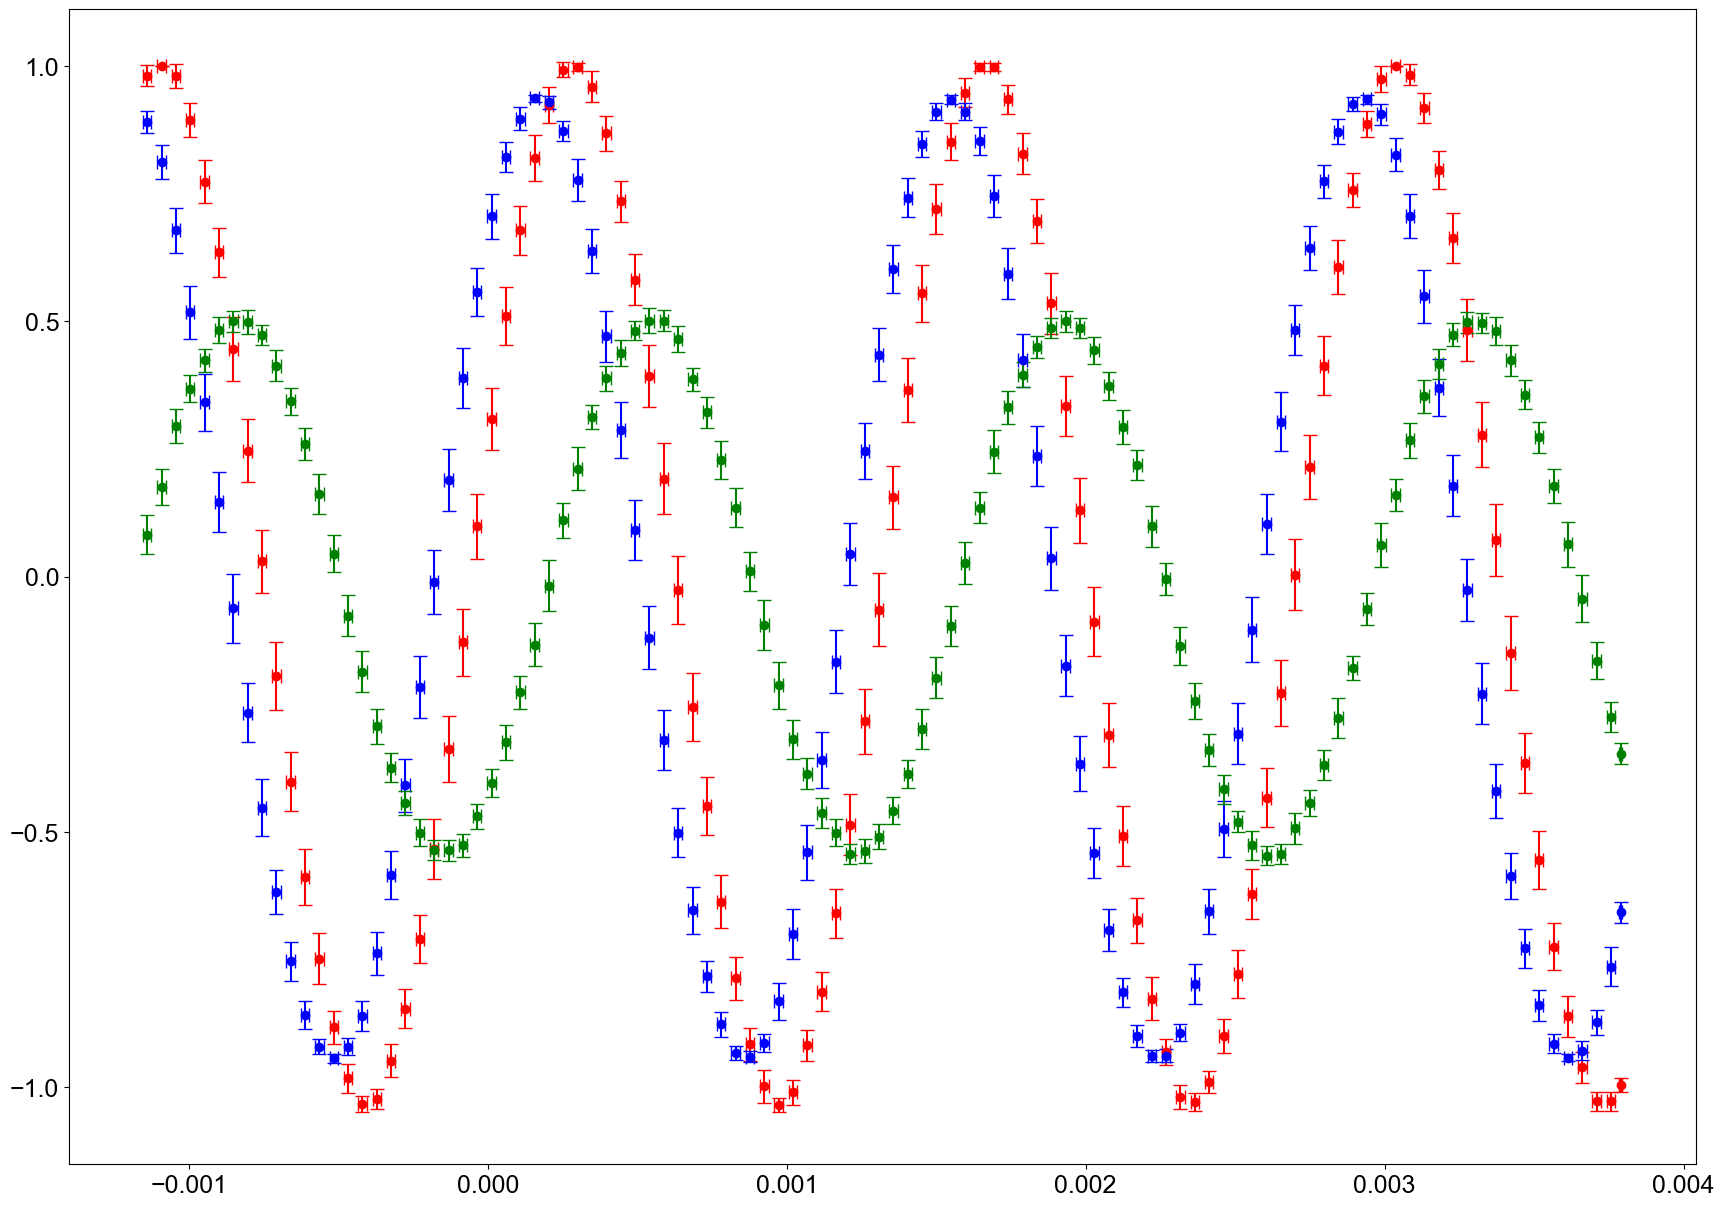

In [11]:
#plot one example of clustered data (CH1, CH2 and MTH)
data_gen = pd.read_csv("data/RC/725_1/CH1_clustered.CSV")
data_ch2 = pd.read_csv("data/RC/725_1/CH2_clustered.CSV")
data_math = pd.read_csv("data/RC/725_1/MTH_clustered.CSV")
plt.errorbar(data_gen["time"], data_gen["voltage"], xerr=data_gen["time_err"], yerr=data_gen["voltage_err"], fmt="ro")
plt.errorbar(data_ch2["time"], data_ch2["voltage"], xerr=data_ch2["time_err"], yerr=data_ch2["voltage_err"], fmt="bo")
plt.errorbar(data_math["time"], data_math["voltage"], xerr=data_math["time_err"], yerr=data_math["voltage_err"], fmt="go")


<ErrorbarContainer object of 3 artists>

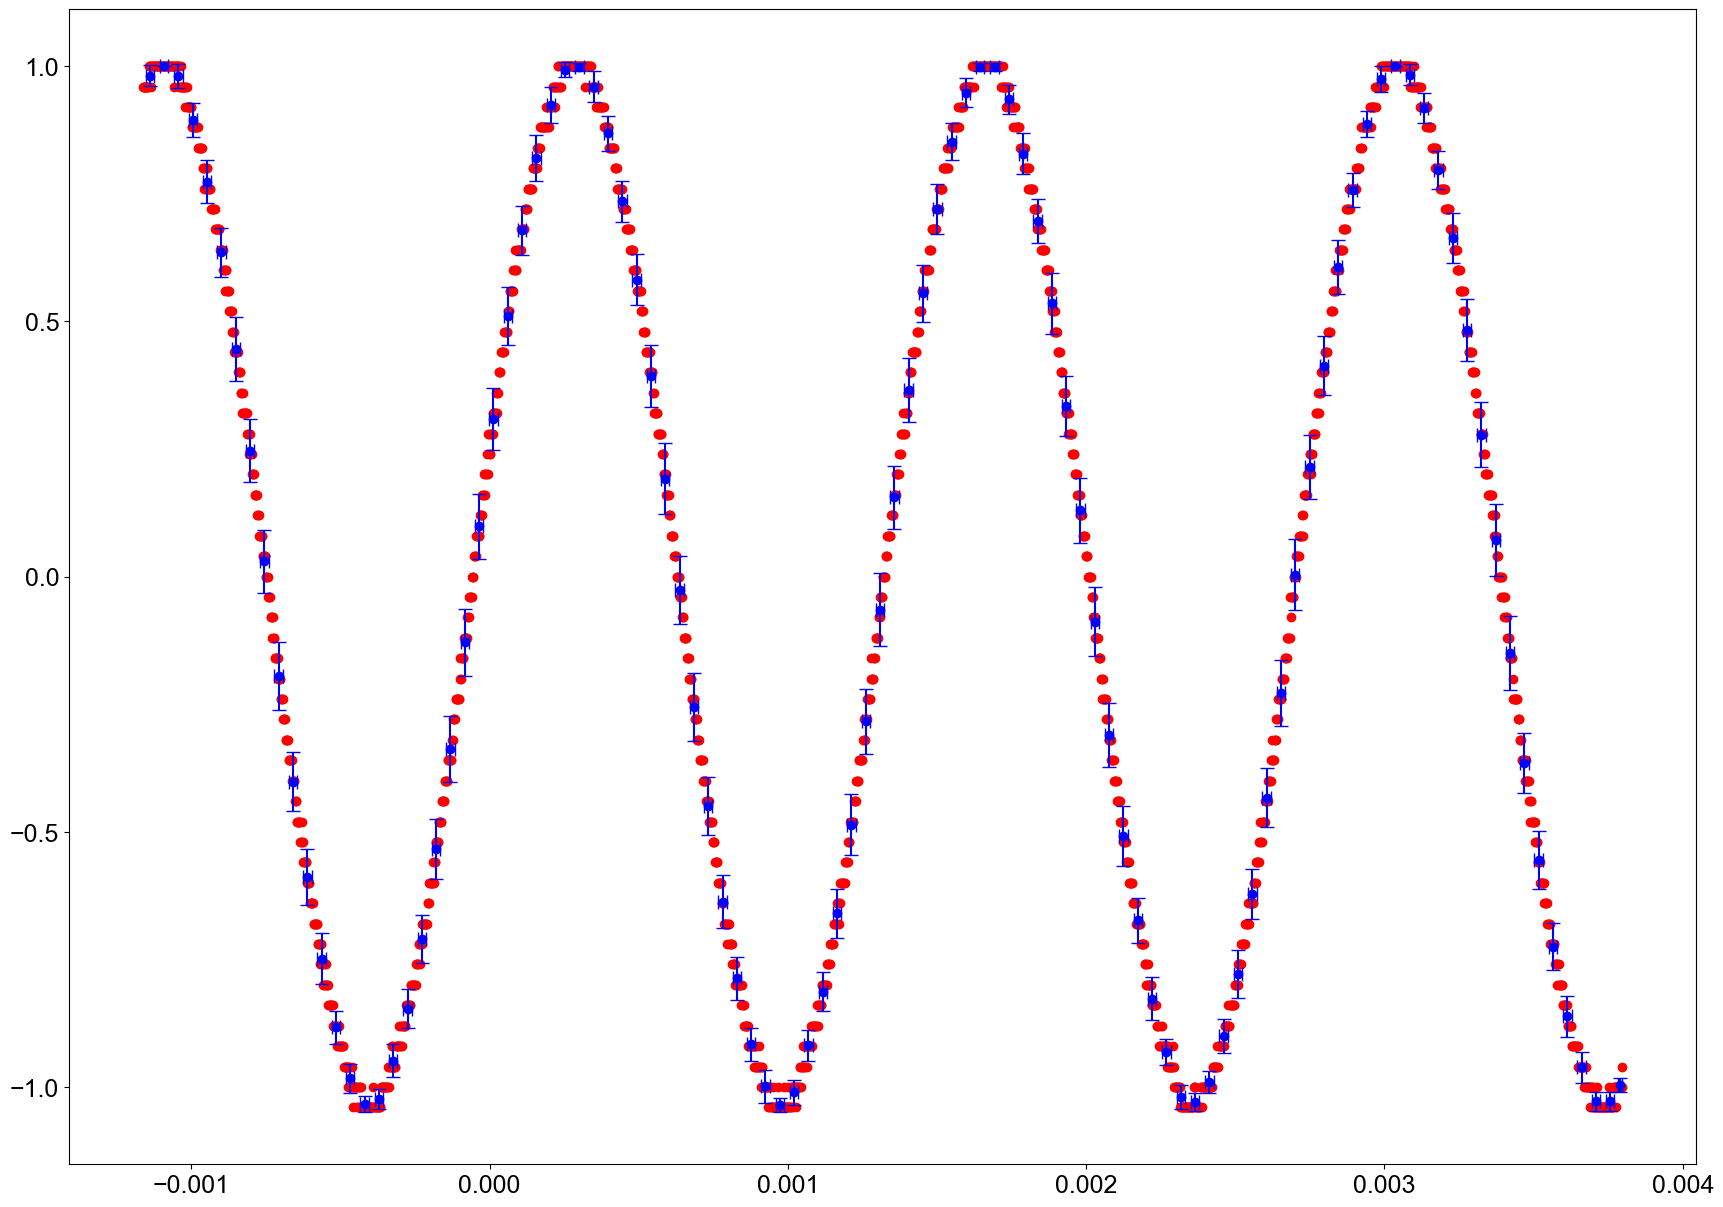

In [80]:
test_data = pd.read_csv("data/RC/725_1/F0000CH1.CSV")
test_data_2 = pd.read_csv("data/RC/1056/F0000CH1.CSV")
test_data = test_data.iloc[18:]
test_data_2 = test_data_2.iloc[18:]
test_data = test_data.iloc[:,[3,4]]
test_data_2 = test_data_2.iloc[:,[3,4]]
test_data.columns = ["time", "voltage"]
test_data_2.columns = ["time", "voltage"]
plt.plot(test_data["time"], test_data["voltage"], "ro")

test_clustered_data = lu.simple_sampling(test_data["time"], test_data["voltage"], 100)
test_clustered_data_2 = lu.simple_sampling(test_data_2["time"], test_data_2["voltage"], 100)
plt.errorbar(test_clustered_data[0], test_clustered_data[1], xerr=test_clustered_data[2], yerr=test_clustered_data[3], fmt="bo")

In [95]:
amp_test, err_amp_test = findAmplitude(test_clustered_data, 725.1)
print(amp_test, err_amp_test)



1.0154166666666669 0.017497165303293934


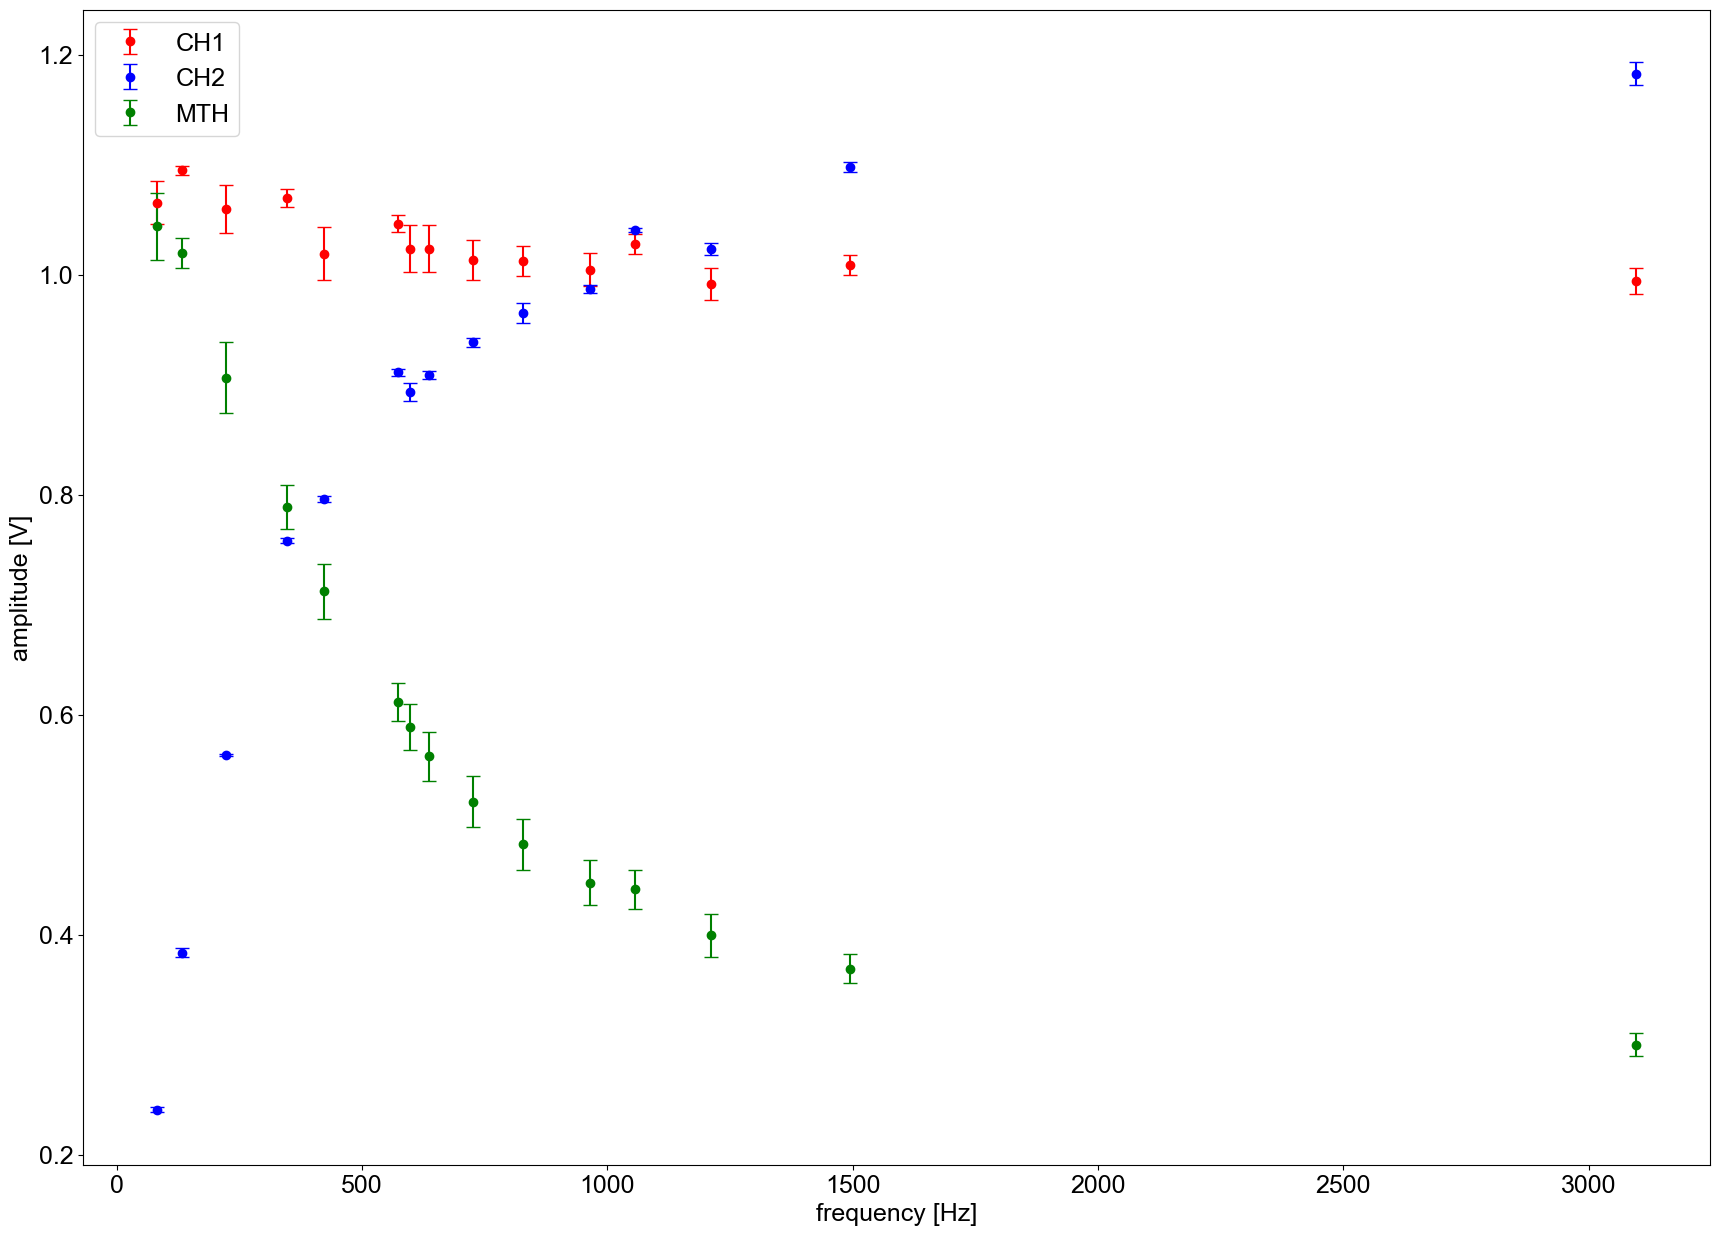

In [162]:
#calculate amplitude
amplitude_CH1_list = []
err_amplitude_CH1_list = []
amplitude_CH2_list = []
err_amplitude_CH2_list = []
amplitude_MTH_list = []
err_amplitude_MTH_list = []
for folder in os.listdir("data/RC"):
    #check if the folder is a folder
    if os.path.isdir("data/RC/"+folder):
        #read CH1, CH2 and MTH data
        data_gen = pd.read_csv("data/RC/"+folder+"/CH1_clustered.CSV")
        data_ch2 = pd.read_csv("data/RC/"+folder+"/CH2_clustered.CSV")
        data_math = pd.read_csv("data/RC/"+folder+"/MTH_clustered.CSV")
        freq_str = folder.replace("_", ".")
        freq = float(freq_str)
        #calculate the amplitude
        #make data_gen a touple of three lists
        data_gen_a = (data_gen["time"].to_list(), data_gen["voltage"].to_list(), data_gen["time_err"].to_list(), data_gen["voltage_err"].to_list())
        data_ch2_a = (data_ch2["time"].to_list(), data_ch2["voltage"].to_list(), data_ch2["time_err"].to_list(), data_ch2["voltage_err"].to_list())
        data_math_a = (data_math["time"].to_list(), data_math["voltage"].to_list(), data_math["time_err"].to_list(), data_math["voltage_err"].to_list())
        amplitude_CH1, err_amplitude_CH1 = findAmplitude(data_gen_a, freq)
        amplitude_CH2, err_amplitude_CH2 = findAmplitude(data_ch2_a, freq)
        amplitude_MTH, err_amplitude_MTH = findAmplitude(data_math_a, freq)
        #add the amplitude to the list
        amplitude_CH1_list.append(amplitude_CH1)
        err_amplitude_CH1_list.append(err_amplitude_CH1)
        amplitude_CH2_list.append(amplitude_CH2)
        err_amplitude_CH2_list.append(err_amplitude_CH2)
        amplitude_MTH_list.append(amplitude_MTH)
        err_amplitude_MTH_list.append(err_amplitude_MTH)

#plot the amplitude
plt.errorbar(freqencies, amplitude_CH1_list, yerr=err_amplitude_CH1_list, fmt="ro")
plt.errorbar(freqencies, amplitude_CH2_list, yerr=err_amplitude_CH2_list, fmt="bo")
plt.errorbar(freqencies, amplitude_MTH_list, yerr=err_amplitude_MTH_list, fmt="go")
plt.xlabel("frequency [Hz]")
plt.ylabel("amplitude [V]")
plt.legend(["CH1", "CH2", "MTH"])

In [8]:
def ampCalc(path):
    amplitude_CH1_list = []
    err_amplitude_CH1_list = []
    amplitude_CH2_list = []
    err_amplitude_CH2_list = []
    amplitude_MTH_list = []
    err_amplitude_MTH_list = []
    for folder in os.listdir(path):
        if (os.path.isdir(path+folder) and folder.replace("_", "").isnumeric()):
        #read CH1, CH2 and MTH data
            data_gen = pd.read_csv(path+folder+"/CH1_clustered.CSV")
            data_ch2 = pd.read_csv(path+folder+"/CH2_clustered.CSV")
            data_math = pd.read_csv(path+folder+"/MTH_clustered.CSV")
            freq_str = folder.replace("_", ".")
            freq = float(freq_str)
            #calculate the amplitude
            #make data_gen a touple of three lists
            data_gen_a = (data_gen["time"].to_list(), data_gen["voltage"].to_list(), data_gen["time_err"].to_list(), data_gen["voltage_err"].to_list())
            data_ch2_a = (data_ch2["time"].to_list(), data_ch2["voltage"].to_list(), data_ch2["time_err"].to_list(), data_ch2["voltage_err"].to_list())
            data_math_a = (data_math["time"].to_list(), data_math["voltage"].to_list(), data_math["time_err"].to_list(), data_math["voltage_err"].to_list())
            amplitude_CH1, err_amplitude_CH1 = findAmplitude(data_gen_a, freq)
            amplitude_CH2, err_amplitude_CH2 = findAmplitude(data_ch2_a, freq)
            amplitude_MTH, err_amplitude_MTH = findAmplitude(data_math_a, freq)
            #add the amplitude to the list
            amplitude_CH1_list.append(amplitude_CH1)
            err_amplitude_CH1_list.append(err_amplitude_CH1)
            amplitude_CH2_list.append(amplitude_CH2)
            err_amplitude_CH2_list.append(err_amplitude_CH2)
            amplitude_MTH_list.append(amplitude_MTH)
            err_amplitude_MTH_list.append(err_amplitude_MTH)

    return amplitude_CH1_list, err_amplitude_CH1_list, amplitude_CH2_list, err_amplitude_CH2_list, amplitude_MTH_list, err_amplitude_MTH_list

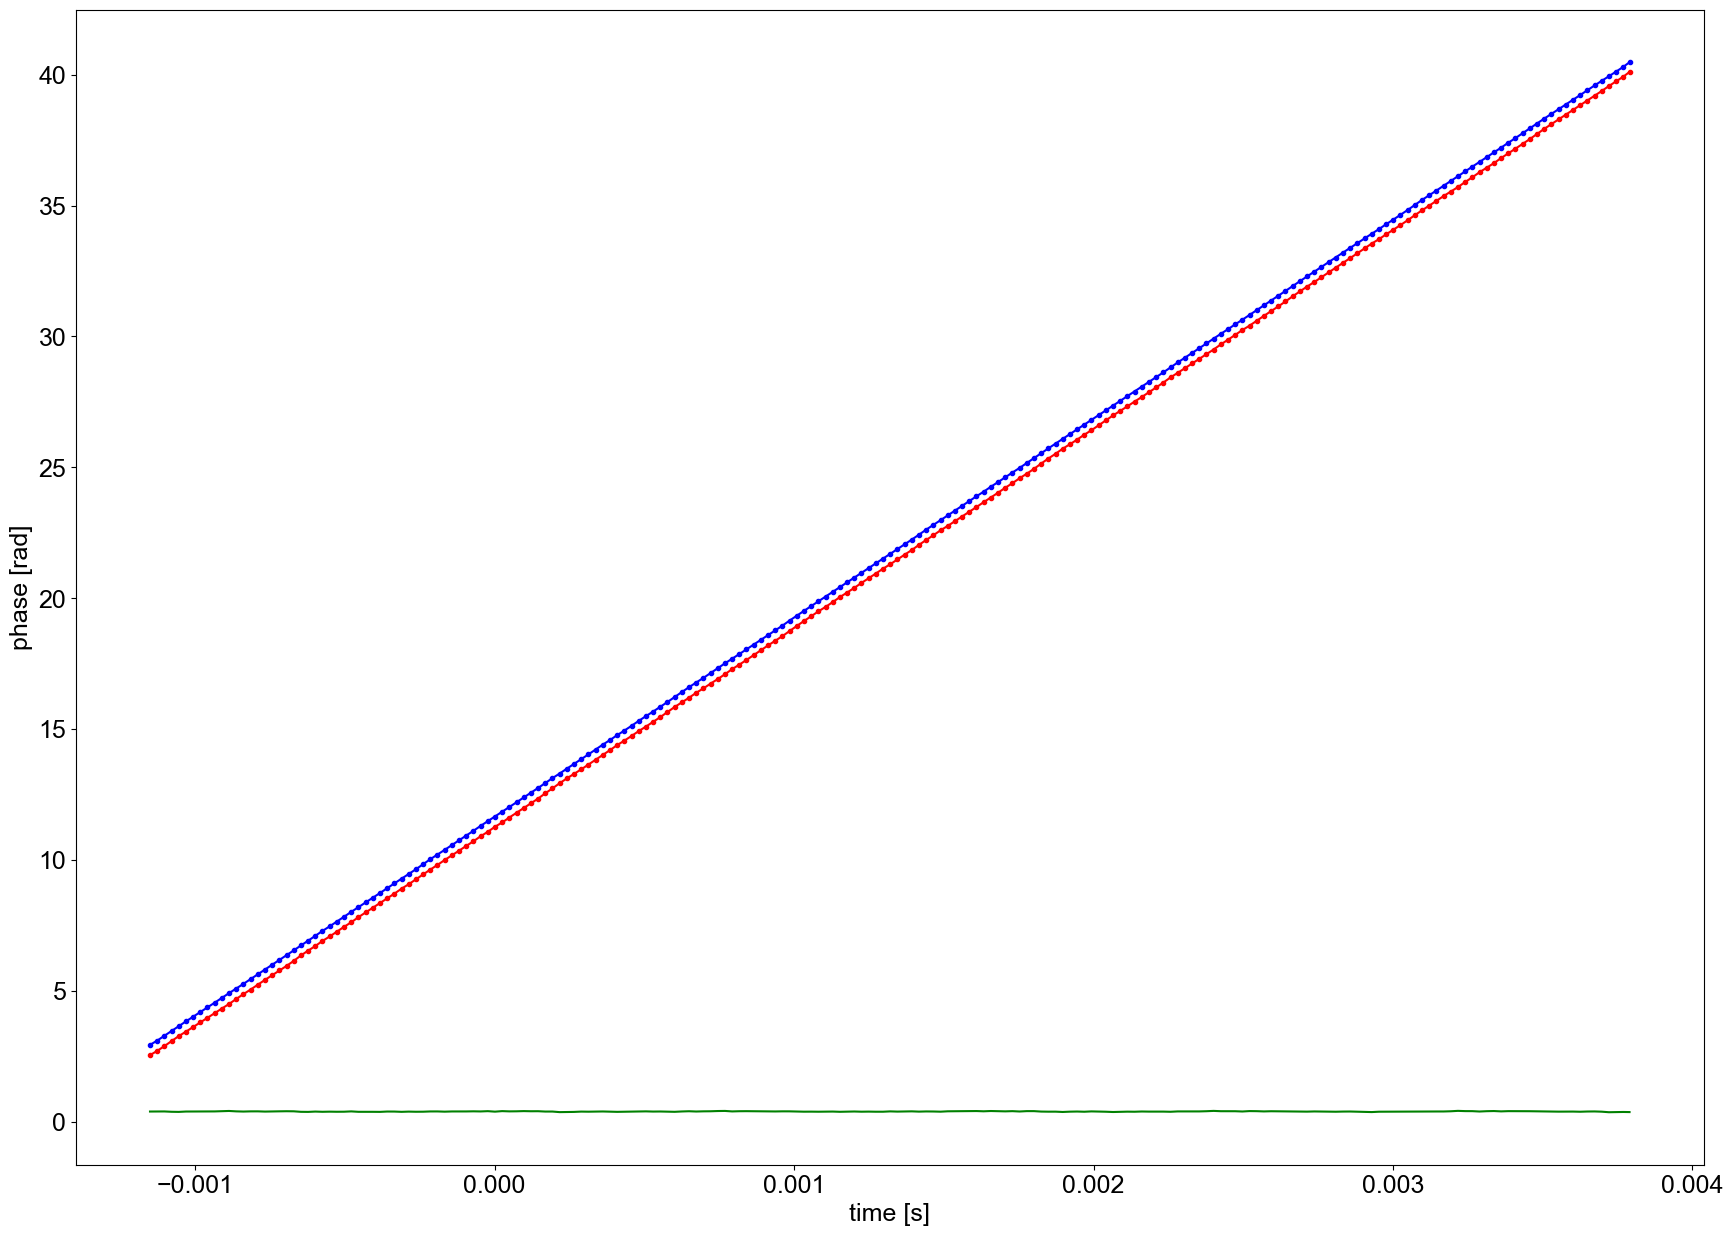

In [52]:
#TEST WITH HILBERT TRANSFORM
test_signal = pd.read_csv("data/RC/1210/F0000CH1.CSV")
test_signal_2 = pd.read_csv("data/RC/1210/F0000CH2.CSV")
test_signal = test_signal.iloc[18:]
test_signal_2 = test_signal_2.iloc[18:]
test_signal = test_signal.iloc[:,[3,4]]
test_signal_2 = test_signal_2.iloc[:,[3,4]]
test_signal.columns = ["time", "voltage"]
test_signal_2.columns = ["time", "voltage"]
test_signal = lu.simple_sampling(test_signal["time"], test_signal["voltage"], 200)
test_signal_2 = lu.simple_sampling(test_signal_2["time"], test_signal_2["voltage"], 200)
test_signal_v = test_signal[1]
test_signal_v_2 = test_signal_2[1]
#calculate Hilbert transform
H = hilbert(test_signal_v)
H_2 = hilbert(test_signal_v_2)
#plot Hilbert transform
#plt.plot(test_signal[0], np.abs(H), "r-")
#plt.plot(test_signal_2[0], np.abs(H_2), "b-")
#find phase
phase = np.unwrap(np.angle(H))
phase_2 = np.unwrap(np.angle(H_2))
#plot phase
plt.plot(test_signal[0], phase, "r.-")
plt.plot(test_signal_2[0], phase_2, "b.-")
#lables
plt.xlabel("time [s]")
plt.ylabel("phase [rad]")
#phase difference
phase_diff = phase_2 - phase
plt.plot(test_signal[0], phase_diff, "g-")

In [53]:
#mean phase difference (from t=0 to t =0.003)
mean_phase_diff = np.mean(phase_diff[20:170])
print(mean_phase_diff)
print(lu.st_dev(phase_diff[20:170]))

0.39340532575790527
0.009325195544794107


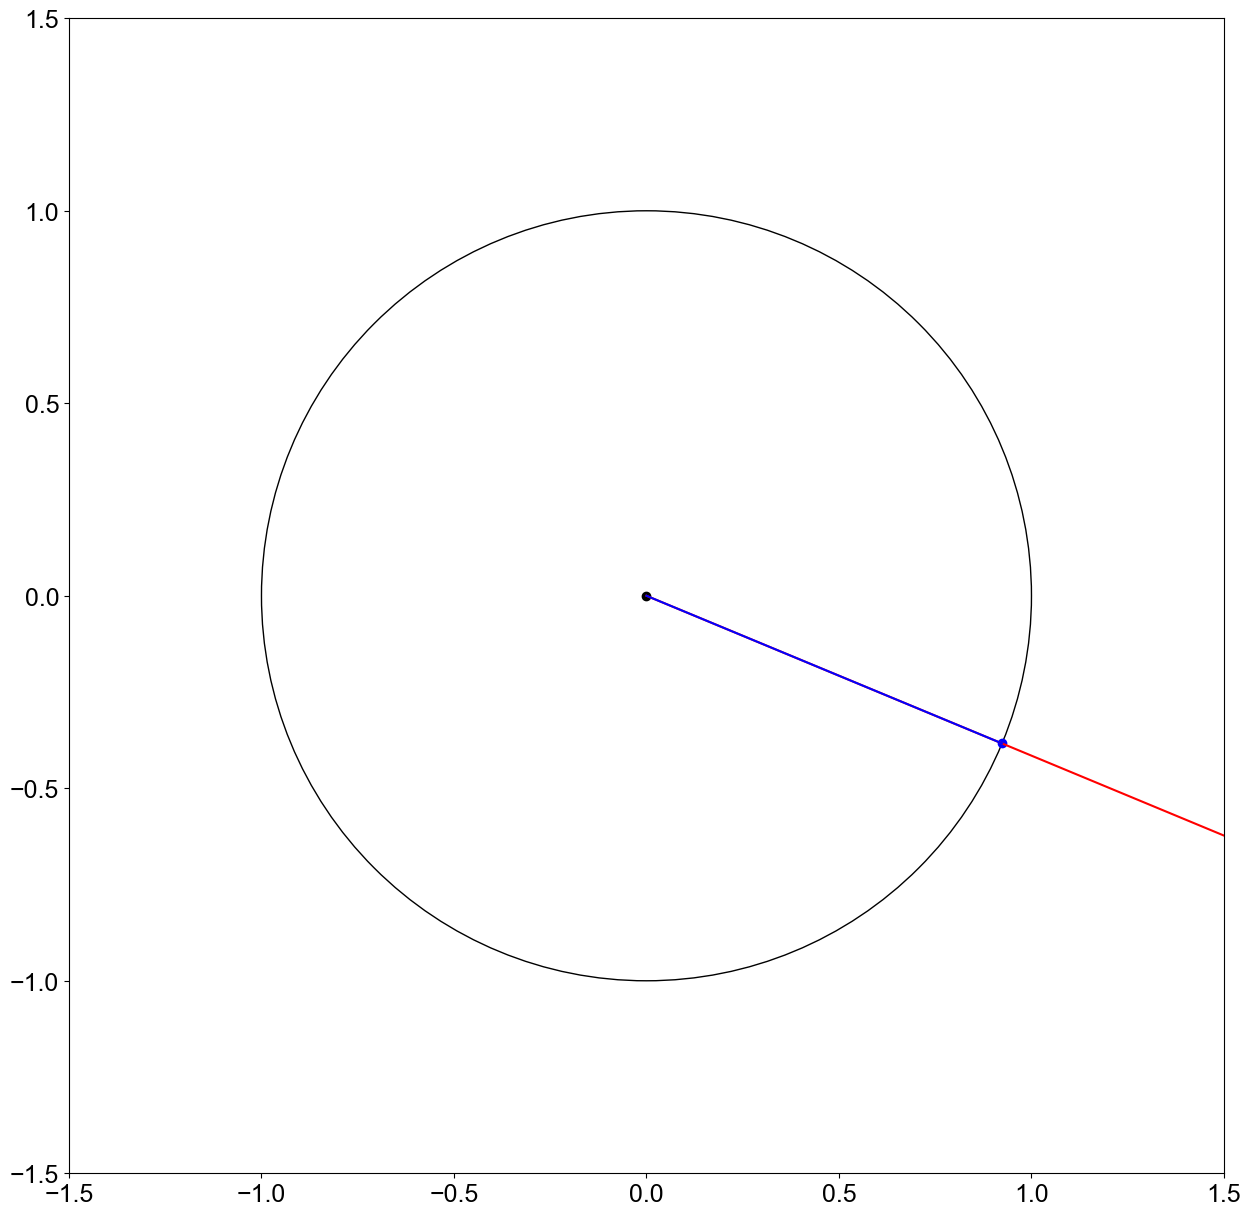

In [54]:
#plot real and imaginary part
p_diff = np.inner(H, np.conjugate(H_2))
normalization_term = np.sqrt(np.inner(H, np.conjugate(H))*np.inner(H_2, np.conjugate(H_2)))
diff = p_diff/normalization_term
#plt.plot(test_signal[0], p_diff, "g-")
#plot unit circle
circle = plt.Circle((0, 0), 1, color='k', fill=False)
ax = plt.gca()
ax.add_artist(circle)
#plot (0,0) as x
plt.plot(0, 0, "ko")


#plot as single point p_diff
plt.plot(p_diff.real, p_diff.imag, "ro")
plt.plot(diff.real, diff.imag, "bo")

#set plot range
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

#make xscale and yscale equal
plt.gca().set_aspect('equal', adjustable='box')

#add lines connecting 0 and p_diff and 0 and diff
plt.plot([0, p_diff.real], [0, p_diff.imag], "r-")
plt.plot([0, diff.real], [0, diff.imag], "b-")

In [55]:
print(np.angle(p_diff))
print(np.angle(diff))

-0.39358101585669314
-0.3935810158566931


In [9]:
def freqList(path):
    freq_list = []
    for folder in os.listdir(path):
        if os.path.isdir(path+folder) and folder.replace("_", "").isnumeric():
            freq_str = folder.replace("_", ".")
            freq = float(freq_str)
            freq_list.append(freq)
    return freq_list

### RC

In [71]:
amplitudes_RC = ampCalc("data/RC/")
phase_diff_RC = phaseDiffCalc("data/RC/", 10000)
freq_list = freqList("data/RC/")
#create a pd dataframe
RC_table = pd.DataFrame({"frequency": freq_list, "amplitude_CH1": amplitudes_RC[0], "err_amplitude_CH1": amplitudes_RC[1], "amplitude_CH2": amplitudes_RC[2], "err_amplitude_CH2": amplitudes_RC[3], "amplitude_MTH": amplitudes_RC[4], "err_amplitude_MTH": amplitudes_RC[5], "phase_diff_ch1_ch2": phase_diff_RC[0], "err_phase_diff_ch1_ch2": phase_diff_RC[1], "phase_diff_ch1_mth": phase_diff_RC[2], "err_phase_diff_ch1_mth": phase_diff_RC[3]})
#save the table
RC_table.to_csv("data/RC/RC_table.csv", index=False)

In [72]:
rc_loaded_table = pd.read_csv("data/RC/RC_table.csv")
rc_loaded_table.head()

,frequency,amplitude_CH1,err_amplitude_CH1,amplitude_CH2,err_amplitude_CH2,amplitude_MTH,err_amplitude_MTH,phase_diff_ch1_ch2,err_phase_diff_ch1_ch2,phase_diff_ch1_mth,err_phase_diff_ch1_mth
0,1056.0,1.027917,0.009167,1.040417,0.001984,0.441250,0.017918,-0.413561,0.01485,1.442216,0.016154
1,1210.0,0.991667,0.014472,1.023182,0.005759,0.399697,0.019477,-0.392737,0.01485,1.480922,0.016154
2,132.5,1.094667,0.004354,0.383889,0.004037,1.019667,0.013406,-1.176778,0.01485,0.346657,0.016154
3,1495.0,1.008889,0.009215,1.097619,0.004499,0.369286,0.013432,-0.346507,0.01485,1.591870,0.016154
4,222.6,1.060000,0.021794,0.563542,0.001049,0.906250,0.032300,-0.963668,0.01485,0.549533,0.016154


In [194]:
R_test = 9.9e3
C_test = 47e-9
#calculate cutoff frequency
cut_off_freq = 1/(2*np.pi*R_test*C_test)
print(cut_off_freq)

342.0480186801963


In [190]:
def H1_RC_Vg_Vz(freq, R, C): #\frac{1}{\sqrt{1+4\pi^2\nu^2R^2C^2}}
    return 1./np.sqrt(1+4*(np.pi**2)*(freq**2)*R**2*C**2)

def H2_RC_Vgz_Vz(freq, R, C):
    return (2*np.pi*freq*R*C)/np.sqrt(1+4*(np.pi**2)*(freq**2)*R**2*C**2)

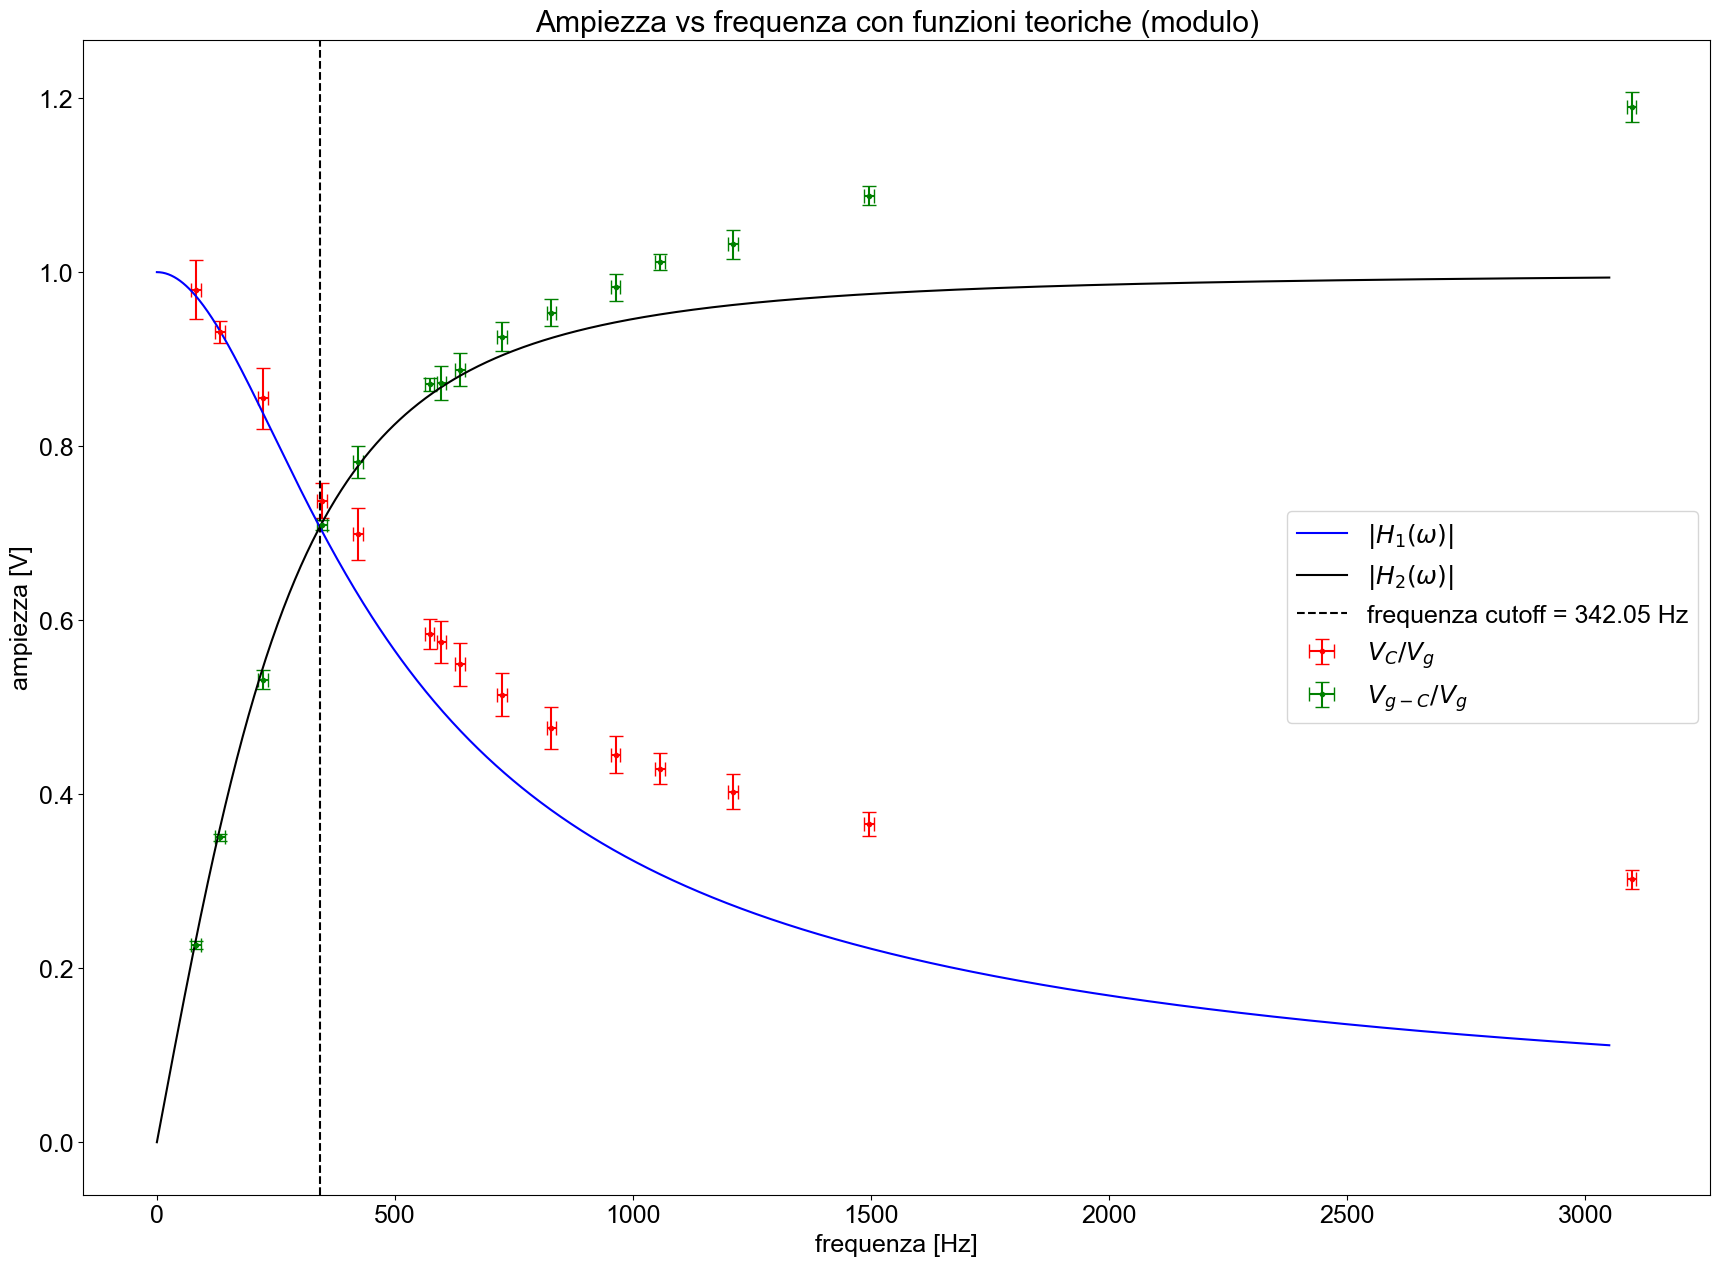

In [228]:
amp_Vgz_Vg = lu.ldivide(rc_loaded_table["amplitude_CH2"].to_list(), rc_loaded_table["amplitude_CH1"].to_list())
err_amp_Vgz_Vg = [np.sqrt((rc_loaded_table["err_amplitude_CH2"].to_list()[i]/rc_loaded_table["amplitude_CH1"].to_list()[i])**2 + (rc_loaded_table["err_amplitude_CH1"].to_list()[i]*rc_loaded_table["amplitude_CH2"].to_list()[i]/(rc_loaded_table["amplitude_CH1"].to_list()[i]**2))**2) for i in range(len(rc_loaded_table["amplitude_CH1"].to_list()))]
amp_Vz_Vg = lu.ldivide(rc_loaded_table["amplitude_MTH"].to_list(), rc_loaded_table["amplitude_CH1"].to_list())
err_amp_Vz_Vg = [np.sqrt((rc_loaded_table["err_amplitude_MTH"].to_list()[i]/rc_loaded_table["amplitude_CH1"].to_list()[i])**2 + (rc_loaded_table["err_amplitude_CH1"].to_list()[i]*rc_loaded_table["amplitude_MTH"].to_list()[i]/(rc_loaded_table["amplitude_CH1"].to_list()[i]**2))**2) for i in range(len(rc_loaded_table["amplitude_CH1"].to_list()))]

R_test = 9.9e3
C_test = 47e-9

#use slider in grpah to change R and C

freqs = rc_loaded_table["frequency"].to_list()
#use latex for labels
plt.errorbar(freqs, amp_Vz_Vg,xerr=10, yerr=err_amp_Vz_Vg, fmt="r.", label="$V_C/V_g$")
plt.errorbar(freqs, amp_Vgz_Vg,xerr=10, yerr=err_amp_Vgz_Vg, fmt="g.", label="$V_{g-C}/V_g$")
freq_linspace = np.linspace(0, 3050, 1000)
hyps = H1_RC_Vg_Vz(freq_linspace, R_test, C_test)
hyps_2 = H2_RC_Vgz_Vz(freq_linspace, R_test, C_test)
plt.plot(freq_linspace, hyps, "b-", label="$|H_1(\omega)|$")
plt.plot(freq_linspace, hyps_2, "k-", label="$|H_2(\omega)|$")
#add vertical line at cutoff frequency
plt.axvline(x=cut_off_freq, color="k", linestyle="--", label="frequenza cutoff = {:.2f} Hz".format(cut_off_freq))
plt.xlabel("frequenza [Hz]")
plt.ylabel("ampiezza [V]")
plt.title("Ampiezza vs frequenza con funzioni teoriche (modulo)")
plt.legend()
plt.show()

In [67]:
from scipy.optimize import curve_fit

In [182]:
def H1_pdiff_Vz_Vg(freq, R, C):
    return -np.arctan(2*np.pi*freq*R*C)

def H2_pdiff_Vgz_Vg(freq, R, C):
    return np.arctan(1/(2*np.pi*freq*R*C))

C:\Users\giova\AppData\Local\Temp\ipykernel_160340\3073773801.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.arctan(1/(2*np.pi*freq*R*C))


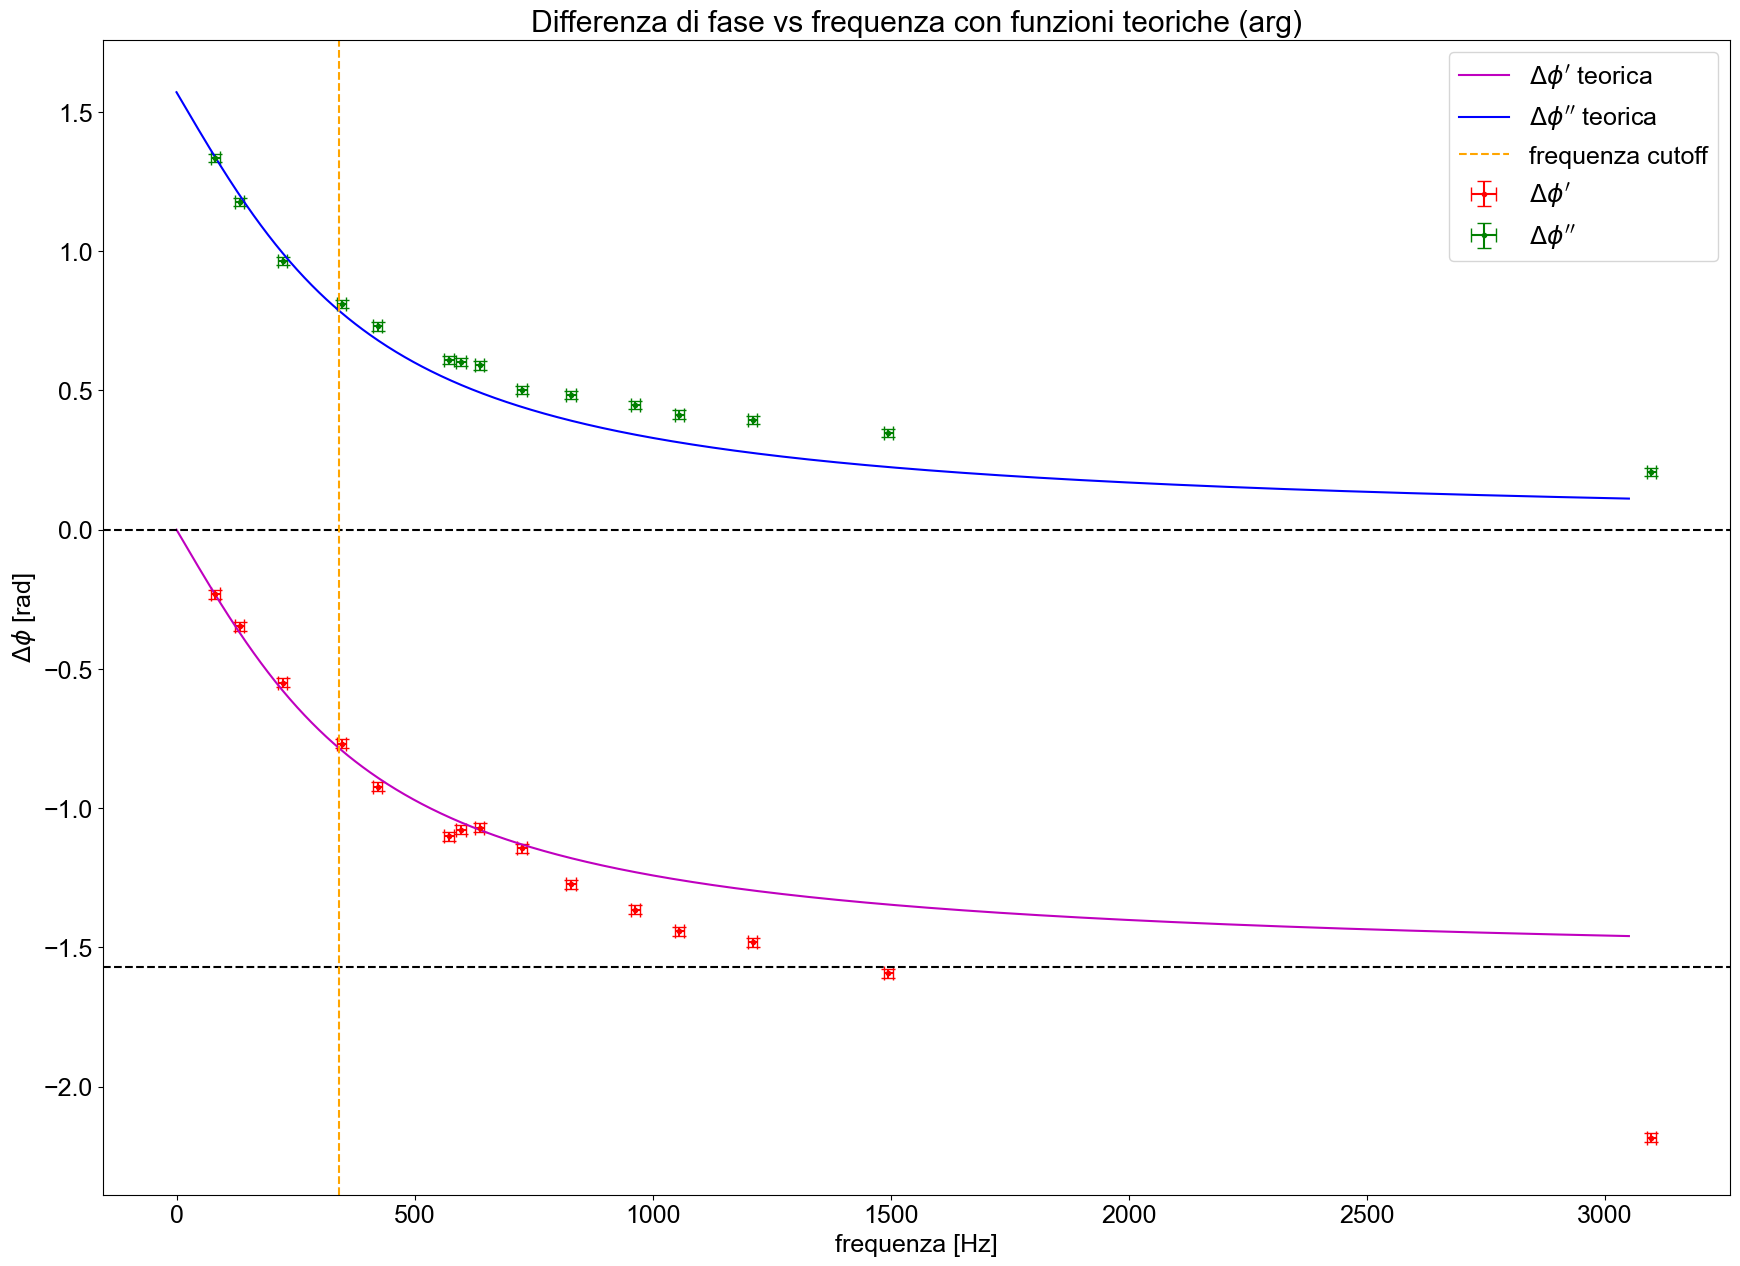

In [231]:
#phase
phase_Vz_Vg = lu.lmultiply(rc_loaded_table["phase_diff_ch1_mth"].to_list(), -1)
err_phase_Vz_Vg = rc_loaded_table["err_phase_diff_ch1_mth"].to_list()
phase_Vgz_Vg = lu.lmultiply(rc_loaded_table["phase_diff_ch1_ch2"].to_list(), -1)
err_phase_Vgz_Vg = rc_loaded_table["err_phase_diff_ch1_ch2"].to_list()

err_freq =[10 for i in range(len(rc_loaded_table["frequency"].to_list()))]

#plot
plt.errorbar(freqs, phase_Vz_Vg, yerr=err_phase_Vz_Vg, xerr=err_freq, fmt="r.", label= "$\Delta \phi'$")
plt.errorbar(freqs, phase_Vgz_Vg, yerr=err_phase_Vgz_Vg, xerr=err_freq, fmt="g.", label= "$\Delta \phi''$")
#add theoretical
phase_linspace = np.linspace(0, 3050, 1000)
hyps = H1_pdiff_Vz_Vg(phase_linspace, R_test, C_test)
hyps_2 = H2_pdiff_Vgz_Vg(phase_linspace, R_test, C_test)
plt.plot(phase_linspace, hyps, "m-", label="$\Delta \phi'$ teorica")
plt.plot(phase_linspace, hyps_2, "b-", label="$\Delta \phi''$ teorica")
#plot asimtote at pi/2 and 0 as orizzontal dashed lines
plt.axhline(y=-np.pi/2, color="k", linestyle="--")
plt.axhline(y=0, color="k", linestyle="--")
#plot vertical dotted line at cutoff frequency
plt.axvline(x=cut_off_freq, color="orange", linestyle="--", label="frequenza cutoff")
plt.xlabel("frequenza [Hz]")
plt.ylabel("$\Delta \phi$ [rad]")
#put legend at top right
plt.legend(loc="upper right")
plt.title("Differenza di fase vs frequenza con funzioni teoriche (arg)")

plt.show()


## RL

In [106]:
renameOscilloscope("data/RL/")

In [113]:
clusterData("data/RL/")

In [152]:
amplitude_RL = ampCalc("data/RL/")
phase_diff_RL = phaseDiffCalc("data/RL/", 10000)
freq_list = freqList("data/RL/")
#create a pd dataframe
RL_table = pd.DataFrame({"frequency": freq_list, "amplitude_CH1": amplitude_RL[0], "err_amplitude_CH1": amplitude_RL[1], "amplitude_CH2": amplitude_RL[2], "err_amplitude_CH2": amplitude_RL[3], "amplitude_MTH": amplitude_RL[4], "err_amplitude_MTH": amplitude_RL[5], "phase_diff_ch1_ch2": phase_diff_RL[0], "err_phase_diff_ch1_ch2": phase_diff_RL[1], "phase_diff_ch1_mth": phase_diff_RL[2], "err_phase_diff_ch1_mth": phase_diff_RL[3]})
#save the table
RL_table.to_csv("data/RL/RL_table.csv", index=False)

In [153]:
rl_loaded_table = pd.read_csv("data/RL/RL_table.csv")
rl_loaded_table.head()

,frequency,amplitude_CH1,err_amplitude_CH1,amplitude_CH2,err_amplitude_CH2,amplitude_MTH,err_amplitude_MTH,phase_diff_ch1_ch2,err_phase_diff_ch1_ch2,phase_diff_ch1_mth,err_phase_diff_ch1_mth
0,10760.0,0.974667,0.049052,1.114000,0.054206,0.446667,0.011222,0.413701,0.009610,-1.694872,0.016412
1,15190.0,0.985556,0.050735,1.049048,0.054287,0.568095,0.008789,0.550038,0.012483,-1.349060,0.016269
2,25410.0,1.014583,0.056901,0.862083,0.059432,0.770000,0.017951,0.828925,0.009750,-0.931056,0.011754
3,30190.0,1.009000,0.051929,0.772333,0.055108,0.840000,0.016667,0.943056,0.010656,-0.852837,0.012003
4,37670.0,1.027222,0.052001,0.670833,0.056053,0.905238,0.022266,1.014004,0.013129,-0.715246,0.013754


In [305]:
def H1_RL_Vg_Vz_module(freq, R, L):
    return (2*np.pi*freq*L)/np.sqrt(R**2+4*(np.pi**2)*(freq**2)*L**2)

[-3.55513087e+04  2.71378238e-01]
[[ 5.31032707e+21 -4.05359759e+16]
 [-4.05359759e+16  3.09428274e+11]]


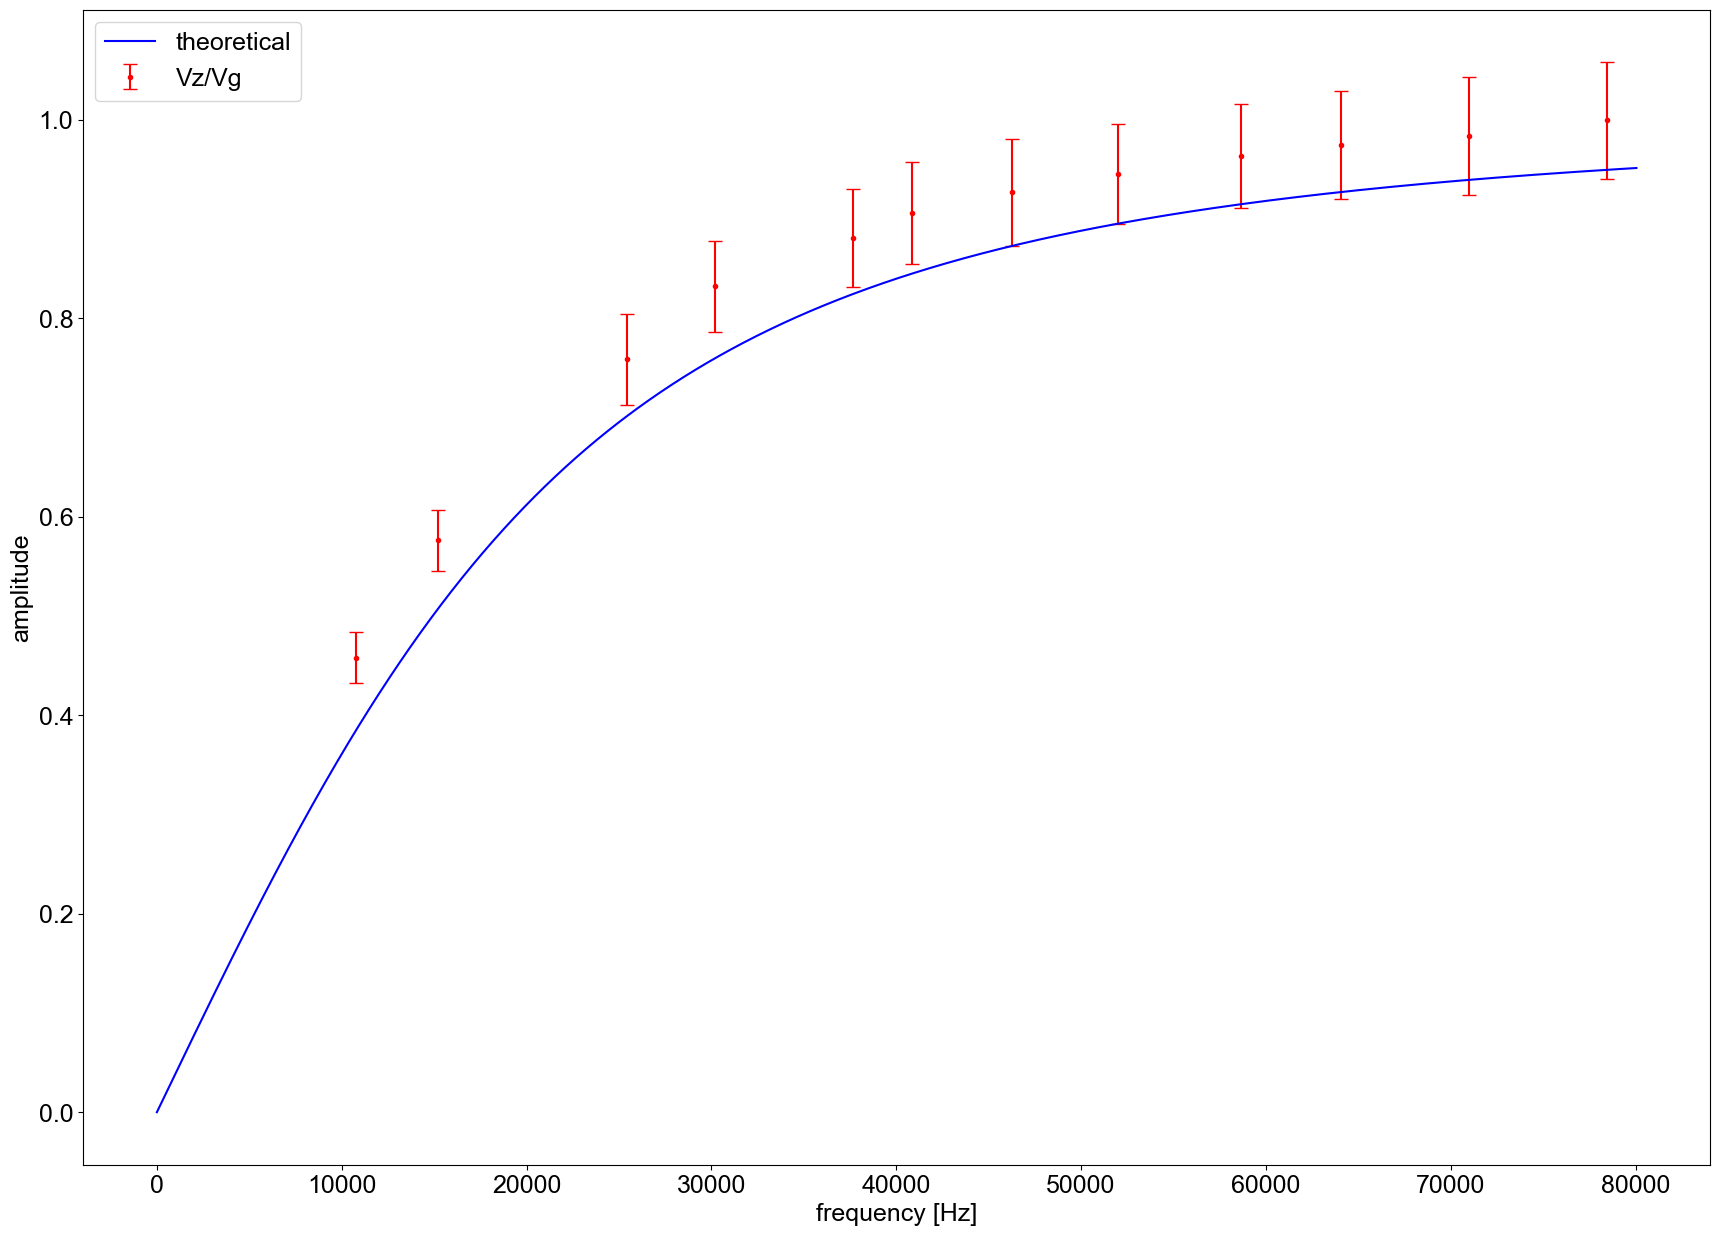

In [306]:
rl_freq = rl_loaded_table["frequency"].to_list()
rl_amp_Vz_Vg = lu.ldivide(rl_loaded_table["amplitude_MTH"].to_list(), rl_loaded_table["amplitude_CH1"].to_list())
rl_amp_Vz_Vg_err = [np.sqrt((rl_loaded_table["err_amplitude_MTH"].to_list()[i]/rl_loaded_table["amplitude_CH1"].to_list()[i])**2 + (rl_loaded_table["err_amplitude_CH1"].to_list()[i]*rl_loaded_table["amplitude_MTH"].to_list()[i]/(rl_loaded_table["amplitude_CH1"].to_list()[i]**2))**2) for i in range(len(rl_loaded_table["amplitude_CH1"].to_list()))]

#fit with the theoretical function
#set initial guess
p0 = [9.9e3, 1e-2]
popt, pcov = curve_fit(H1_RL_Vg_Vz_module, rl_freq, rl_amp_Vz_Vg, sigma=rl_amp_Vz_Vg_err, p0=p0, absolute_sigma=True)
print(popt)
print(pcov)

plt.errorbar(rl_freq, rl_amp_Vz_Vg, yerr=rl_amp_Vz_Vg_err, fmt="r.", label="Vz/Vg")
freq_linspace = np.linspace(0, 80050, 1000)
hyps = H1_RL_Vg_Vz_module(freq_linspace, 9.9e3, 0.061)
plt.plot(freq_linspace, hyps, "b-", label="theoretical")
plt.xlabel("frequency [Hz]")
plt.ylabel("amplitude")
plt.legend()

In [162]:
#phase diff
def H1_RL_Vz_Vg_arg(freq, R, L):
    return np.pi/2 - np.arctan(2*np.pi*freq*L/R)

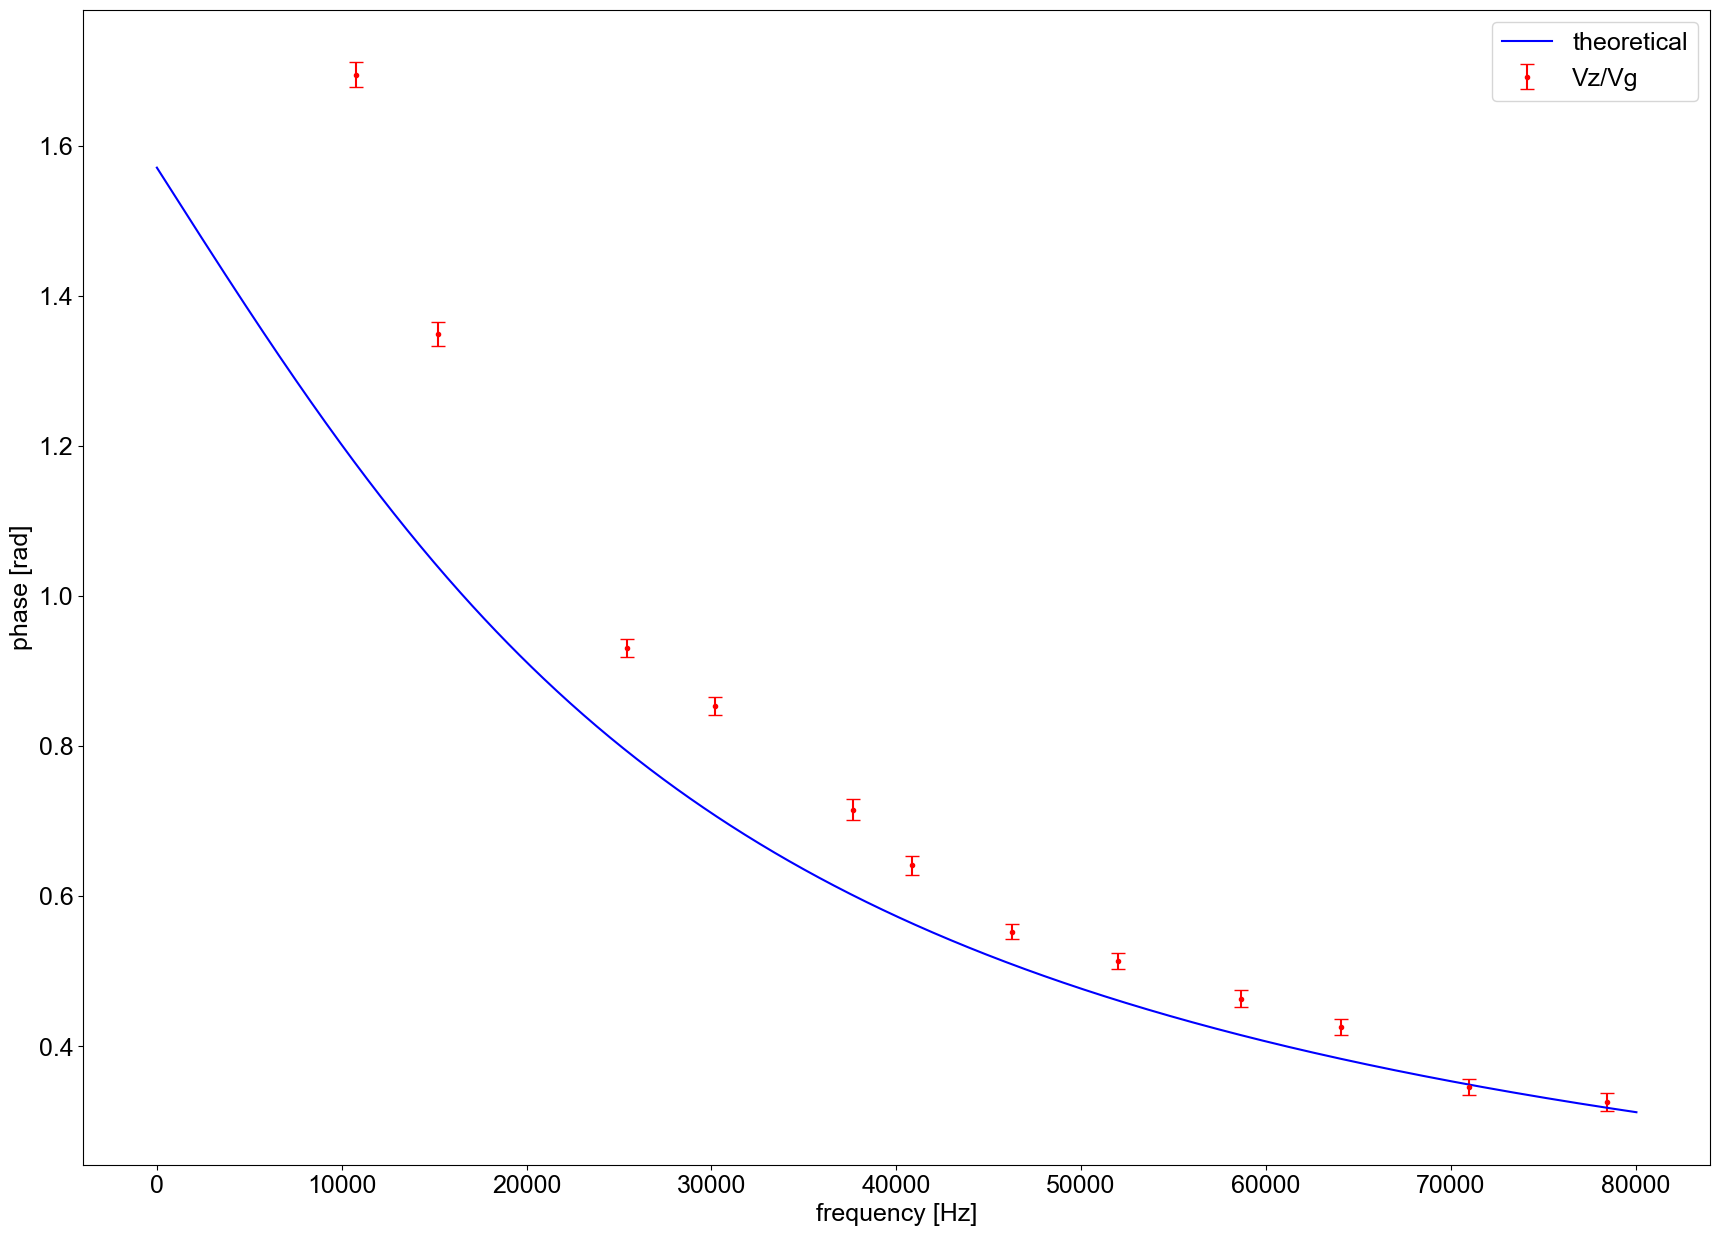

In [307]:
rl_Vz_Vg_pdiff = lu.lmultiply(rl_loaded_table["phase_diff_ch1_mth"].to_list(), -1)
rl_Vz_Vg_pdiff_err = rl_loaded_table["err_phase_diff_ch1_mth"].to_list()

plt.errorbar(rl_freq, rl_Vz_Vg_pdiff, yerr=rl_Vz_Vg_pdiff_err, fmt="r.", label="Vz/Vg")
freq_linspace = np.linspace(0, 80050, 1000)
hyps = H1_RL_Vz_Vg_arg(freq_linspace, 9.9e3, 0.061)
plt.plot(freq_linspace, hyps, "b-", label="theoretical")
plt.xlabel("frequency [Hz]")
plt.ylabel("phase [rad]")
plt.legend()

#### Try to fit misuta induttanza to get a initial value of L

In [303]:
def RL_charge_function(t, R, L, V0):
    return V0*(1 - np.exp(-t/(L/R)))

In [296]:
def RL_charge_function_2(t, tau, V0):
    return V0*(1 - np.exp(-t/tau))

R =  -33178030.102576338  +-  2252531333316.1865
L =  -204.73583609285475  +-  13899988.947858727
V0 =  2.2872000371188643  +-  0.002582162971408064
tau =  6.170826573705147e-06  +-  2.2623588434447324e-08
V0 =  2.2872000395468493  +-  0.002509499021873362


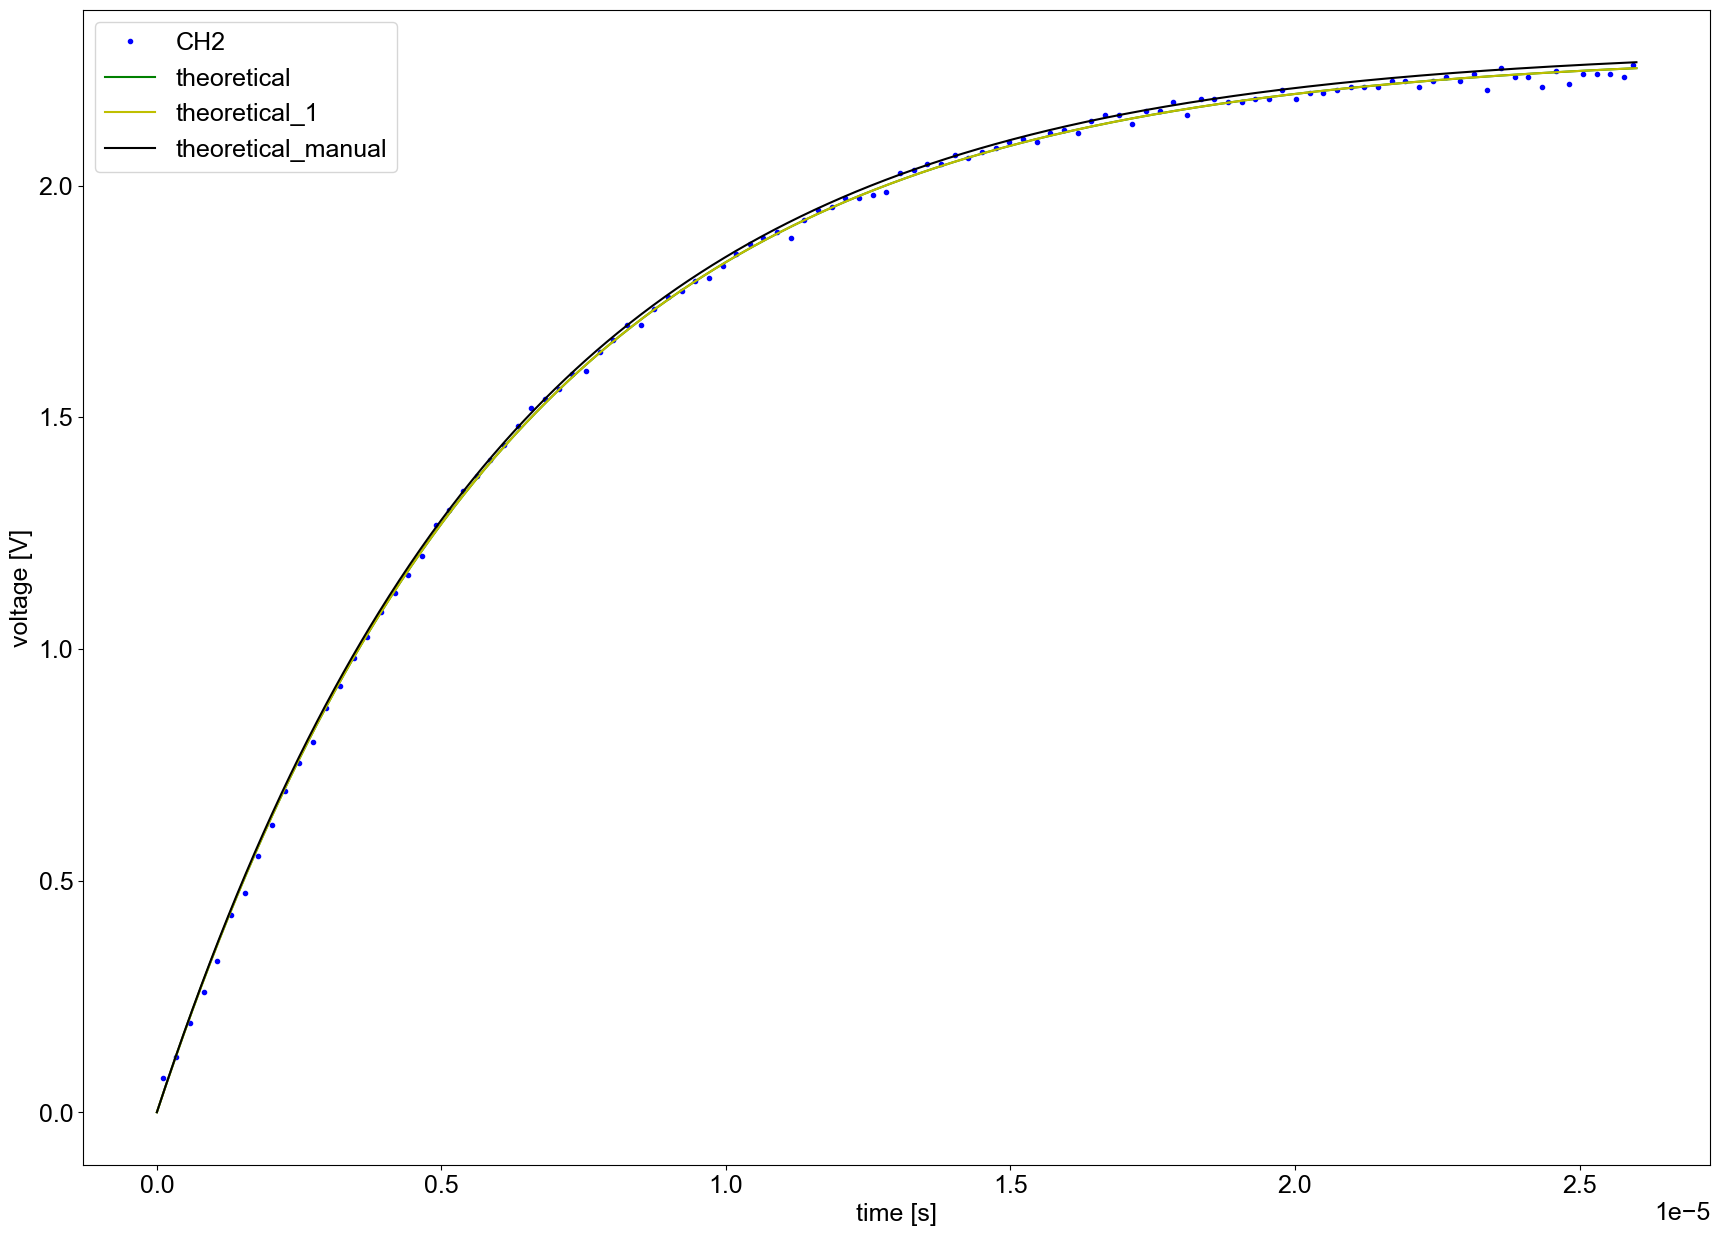

In [311]:
data_ch1_mis_induttanza = pd.read_csv("data/RL/misura_induttanza/F0000CH1.CSV")
data_ch1_mis_induttanza = data_ch1_mis_induttanza.iloc[18:,[3,4]]
data_ch1_mis_induttanza.columns = ["time", "voltage"]
data_ch2_mis_induttanza = pd.read_csv("data/RL/misura_induttanza/F0000CH2.CSV")
data_ch2_mis_induttanza = data_ch2_mis_induttanza.iloc[18:,[3,4]]
data_ch2_mis_induttanza.columns = ["time", "voltage"]

#cut the data to have only the first period
data_ch1_mis_induttanza = data_ch1_mis_induttanza.iloc[280:930,:]
data_ch2_mis_induttanza = data_ch2_mis_induttanza.iloc[280:930,:]
#shift the time to have t=0 for the first item
data_ch1_mis_induttanza["time"] = data_ch1_mis_induttanza["time"] - data_ch1_mis_induttanza["time"].iloc[0]
data_ch2_mis_induttanza["time"] = data_ch2_mis_induttanza["time"] - data_ch2_mis_induttanza["time"].iloc[0]
#cluster the data
data_ch1_mis_induttanza_clust = lu.simple_sampling(data_ch1_mis_induttanza["time"], data_ch1_mis_induttanza["voltage"], 100)
data_ch2_mis_induttanza_clust = lu.simple_sampling(data_ch2_mis_induttanza["time"], data_ch2_mis_induttanza["voltage"], 100)


popt_1, pcov_1 = curve_fit(RL_charge_function, data_ch2_mis_induttanza_clust[0], data_ch2_mis_induttanza_clust[1], p0=[9.9e3, 0.061, 2.3])
popt, pcov = curve_fit(RL_charge_function_2, data_ch2_mis_induttanza_clust[0], data_ch2_mis_induttanza_clust[1], p0=[1.5e-5, 2.3])
print("R = ", popt_1[0], " +- ", np.sqrt(pcov_1[0][0]))
print("L = ", popt_1[1], " +- ", np.sqrt(pcov_1[1][1]))
print("V0 = ", popt_1[2], " +- ", np.sqrt(pcov_1[2][2]))
print("tau = ", popt[0], " +- ", np.sqrt(pcov[0][0]))
print("V0 = ", popt[1], " +- ", np.sqrt(pcov[1][1]))

#plt.plot(data_ch1_mis_induttanza["time"], data_ch1_mis_induttanza["voltage"], "r-", label="CH1")
plt.plot(data_ch2_mis_induttanza_clust[0], data_ch2_mis_induttanza_clust[1], "b.", label="CH2")
#plot fit
time_linspace = np.linspace(0, 2.6e-5, 1000)
hyps_1 = RL_charge_function(time_linspace, popt_1[0], popt_1[1], popt_1[2])
hyps = RL_charge_function_2(time_linspace, popt[0], popt[1])
plt.plot(time_linspace, hyps, "g-", label="theoretical")
plt.plot(time_linspace, hyps_1, "y-", label="theoretical_1")

manual_hyp = RL_charge_function(time_linspace, 9.9e3, 0.061, 2.3)
plt.plot(time_linspace, manual_hyp, "k-", label="theoretical_manual")
plt.xlabel("time [s]")
plt.ylabel("voltage [V]")
plt.legend()


In [287]:
#print time - voltage  as (t, V) to txt file (only CH2)
print("time - voltage values")
print("CH2")
values = []
for i in range(len(data_ch2_mis_induttanza["time"])):
    values.append((data_ch2_mis_induttanza["time"].iloc[i], data_ch2_mis_induttanza["voltage"].iloc[i]))

with open("data/RL/misura_induttanza/time_voltage_CH2.txt", "w") as f:
    for item in values:
        f.write("%s" % item[0] + " " + "%s\n" % item[1])


time - voltage values
CH2


## RLC

### R

In [12]:
renameOscilloscope("data/RLC/R/")

In [13]:
clusterData("data/RLC/R/")

In [14]:
amplitude_RLC_R = ampCalc("data/RLC/R/")
phase_diff_RLC_R = phaseDiffCalc("data/RLC/R/", 10000)
freq_list = freqList("data/RLC/R/")
#create a pd dataframe
RLC_R_table = pd.DataFrame({"frequency": freq_list, "amplitude_CH1": amplitude_RLC_R[0], "err_amplitude_CH1": amplitude_RLC_R[1], "amplitude_CH2": amplitude_RLC_R[2], "err_amplitude_CH2": amplitude_RLC_R[3], "amplitude_MTH": amplitude_RLC_R[4], "err_amplitude_MTH": amplitude_RLC_R[5], "phase_diff_ch1_ch2": phase_diff_RLC_R[0], "err_phase_diff_ch1_ch2": phase_diff_RLC_R[1], "phase_diff_ch1_mth": phase_diff_RLC_R[2], "err_phase_diff_ch1_mth": phase_diff_RLC_R[3]})
#save the table
RLC_R_table.to_csv("data/RLC/R/RLC_R_table.csv", index=False)

In [15]:
RLC_R_loaded_table = pd.read_csv("data/RLC/R/RLC_R_table.csv")
RLC_R_loaded_table.head()

,frequency,amplitude_CH1,err_amplitude_CH1,amplitude_CH2,err_amplitude_CH2,amplitude_MTH,err_amplitude_MTH,phase_diff_ch1_ch2,err_phase_diff_ch1_ch2,phase_diff_ch1_mth,err_phase_diff_ch1_mth
0,1337.0,1.003750,0.006535,1.079722,0.000680,0.337667,0.017780,-0.316108,0.010550,1.653584,0.012988
1,15670.0,0.990952,0.012887,1.045000,0.008819,0.571905,0.017858,0.554678,0.012251,-1.414867,0.014296
2,197.7,1.065185,0.002757,0.522292,0.001652,0.934259,0.025387,-1.070436,0.015111,0.526474,0.015235
3,20880.0,0.988148,0.012588,0.945000,0.007500,0.686167,0.016998,0.704026,0.016358,-1.167764,0.017226
4,28550.0,1.013333,0.013202,0.813667,0.004314,0.810667,0.023172,0.923084,0.010170,-0.922792,0.010435


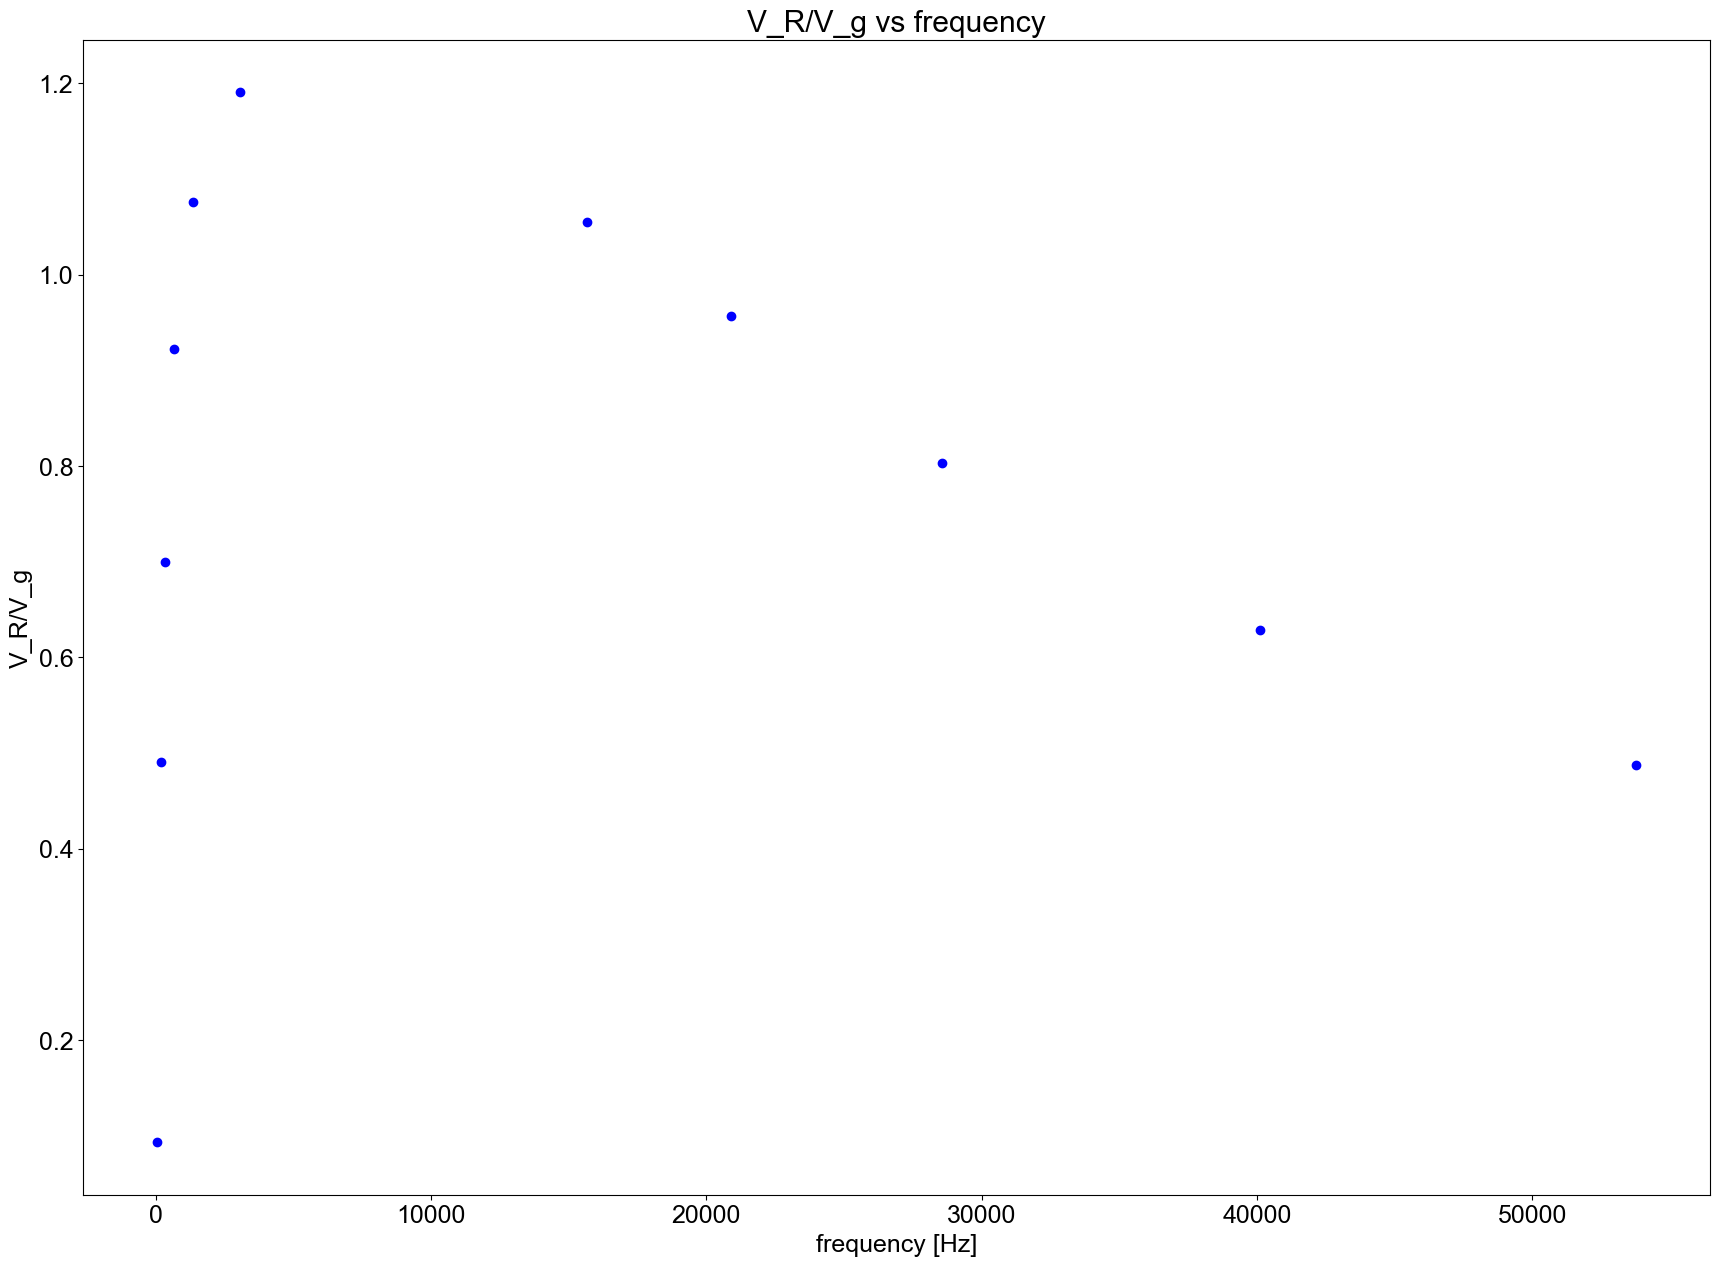

In [17]:
#calculate V_R/V_g (CH2/CH1)
V_R_over_V_g = RLC_R_loaded_table["amplitude_CH2"]/RLC_R_loaded_table["amplitude_CH1"]

#plot V_R/V_g vs frequency
plt.plot(RLC_R_loaded_table["frequency"], V_R_over_V_g, "bo")
plt.xlabel("frequency [Hz]")
plt.ylabel("V_R/V_g")
plt.title("V_R/V_g vs frequency")
plt.show()